# **Прогнозирование стоимости автомобиля по характеристикам**



## 1. Импорт библиотек и подготовка

In [1]:
import numpy as np
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

import re
import sys
import itertools
import datetime
from tqdm.notebook import tqdm
import pandas_profiling
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor
import xgboost as xgb

from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

import warnings
warnings.filterwarnings("ignore")

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 42

In [5]:
# метрика для оценки качества моделей:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## 2. Сбор данных и создание объединенного датасета

Сбор данных напрямую с auto.ru к сожалению оказался непосильной задачей.
Выручили готовые датасеты выложенные на Kaggle. Удалось раздобыть 4 датасета за 2021 год в дополнение к датасету из Baseline. Соответственно, основная задача была грамотно склеить их в один общий и объединить с тестовыми данными.


Загрузим датасеты напрямую из Kaggle:

In [6]:
# Адреса директорий:
DIR_TRAIN0  = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
DIR_TRAIN1 = '../input/final-car-price-prediction-df-parsed-sep-2021/'
DIR_TRAIN2 = '../input/cars-prices-24-05-21-autoru/'
DIR_TRAIN3 = '../input/autoru/'
DIR_TRAIN4 = '../input/autoru-all-used-car-offers-as-of-17032021/'
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

In [7]:
!ls '../input'

autoru
autoru-all-used-car-offers-as-of-17032021
cars-prices-24-05-21-autoru
final-car-price-prediction-df-parsed-sep-2021
parsing-all-moscow-auto-ru-09-09-2020
sf-dst-car-price-prediction


In [8]:
# Загрузка данных:
train0 = pd.read_csv(DIR_TRAIN0+'all_auto_ru_09_09_2020.csv') # Октябрь 2021 из Baseline
train1 = pd.read_csv(DIR_TRAIN1+'train_df_full_part1.csv') # Октябрь 2021
train2 = pd.read_csv(DIR_TRAIN2+'train_parsed_24_05_21.csv') # Май 2021
train3 = pd.read_csv(DIR_TRAIN3+'train.csv') # Апрель 2021
train4 = pd.read_csv(DIR_TRAIN4+'dataset_with_electro.csv') # Март 2021
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [9]:
# Посмотрим что мы имеем в общем виде:
train0.info()
train1.info()
train2.info()
train3.info()
train4.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

До того как объединить трейновые датасеты в один общий, скорректируем цены. Цены на автомобили в России взлетели на 30% в 2021 (данные экспертов-экономистов). Предположим что рост был равномерным, т.е. 2.5% в месяц. Прогноз нужно сделать на октябрь. Скорректируем цены за предыдущие месяцы.

In [10]:
#train2.price = train2.price*(1+0.025*5)
#train3.rice = train3.price*(1+0.025*6)
#train4.price = train4.price*(1+0.025*7)

Выяснялось, однако, что точность предсказания падает при введении коэффициента инфляции.

In [11]:
# Объединим все тестовые датасеты в один по принципу 'outer' и посмотрим на итоговый гиганский датасет:
combined_check = pd.concat([train0, train1, train2, train3, train4], join='outer', ignore_index=True)
combined_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864326 entries, 0 to 864325
Data columns (total 68 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              531427 non-null  object 
 1   brand                 864091 non-null  object 
 2   color                 864091 non-null  object 
 3   fuelType              531435 non-null  object 
 4   modelDate             531427 non-null  float64
 5   name                  531594 non-null  object 
 6   numberOfDoors         531428 non-null  float64
 7   productionDate        531437 non-null  float64
 8   vehicleConfiguration  531431 non-null  object 
 9   vehicleTransmission   531427 non-null  object 
 10  engineDisplacement    531433 non-null  object 
 11  enginePower           531433 non-null  object 
 12  description           518087 non-null  object 
 13  mileage               837137 non-null  float64
 14  Комплектация          89378 non-null   object 
 15  

Видно что многие столбцы дублируются либо по языку написания, либо по сокращениям.

In [12]:
# Приведём столбцы к общим названиям взяв за основу названия из тестового датасета:

for train in [train0, train1, train2, train3, train4, test]:
    train.rename(columns={'Владельцы': 'owners', 'Комплектация': 'complectation_dict',
                          'Владение': 'ownership', 'ПТС': 'vehicle_licence','Привод': 'driving_gear', 'Руль': 'steering_wheel',
                          'Состояние': 'condition', 'Таможня': 'customs'}, inplace=True)
    
for train in [train0, train1, train2, train3, train4, test]:
    train.rename(columns={'model': 'model_name', 'car_url' : 'url', 'owner' : 'ownership',
                         'engine_power' : 'enginePower', 'transmission' : 'vehicleTransmission',
                         'descr' : 'description', 'complectation' : 'complectation_dict', 
                         'owners_count' : 'owners', 'drive' : 'driving_gear', 'pts' : 'vehicle_licence', 
                          'wheel' : 'steering_wheel', 'fuel_type' : 'fuelType', 'body_type' : 'bodyType', 
                          'year' : 'productionDate', 'offer_id' : 'sell_id',
                          'date_posted' : 'date_added', 'engine_volume' : 'engineDisplacement'
                         }, inplace=True)


In [13]:
# Снова объединим трейновые датасеты (теперь с подправленными названиями столбцов):
train = pd.concat([train0, train1, train2, train3, train4], join='outer', ignore_index=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864326 entries, 0 to 864325
Data columns (total 50 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              864074 non-null  object 
 1   brand                 864091 non-null  object 
 2   color                 864091 non-null  object 
 3   fuelType              864082 non-null  object 
 4   modelDate             531427 non-null  float64
 5   name                  531594 non-null  object 
 6   numberOfDoors         531428 non-null  float64
 7   productionDate        864091 non-null  float64
 8   vehicleConfiguration  531431 non-null  object 
 9   vehicleTransmission   864074 non-null  object 
 10  engineDisplacement    864080 non-null  object 
 11  enginePower           864080 non-null  object 
 12  description           838639 non-null  object 
 13  mileage               837137 non-null  float64
 14  complectation_dict    689775 non-null  object 
 15  

In [14]:
# Пометим трейновый и тестовый датасеты и добавим столбец price к тестовому датасету заполнив его нолями:
test['price'] = 0.0
train['train'] = 1
test['train'] = 0


In [15]:
# Объединим трейновый и тестовый датасеты в один общий по принципу 'inner' (отбросив лишние столбцы):
comb_df = pd.concat([train, test], join='inner', ignore_index=True)
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899012 entries, 0 to 899011
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              898760 non-null  object 
 1   brand                 898777 non-null  object 
 2   color                 898777 non-null  object 
 3   fuelType              898768 non-null  object 
 4   modelDate             566113 non-null  float64
 5   name                  566280 non-null  object 
 6   numberOfDoors         566114 non-null  float64
 7   productionDate        898777 non-null  float64
 8   vehicleConfiguration  566117 non-null  object 
 9   vehicleTransmission   898760 non-null  object 
 10  engineDisplacement    898766 non-null  object 
 11  enginePower           898766 non-null  object 
 12  description           873325 non-null  object 
 13  mileage               871823 non-null  float64
 14  complectation_dict    696193 non-null  object 
 15  

## 3. Обработка данных и EDA

In [16]:
# ... 

### 3.1. Первичный EDA (Pandas profiling)

In [17]:
## Сделаем первичный EDA с помощью Pandas profiling
#pandas_profiling.ProfileReport(comb_df)

Pandas profiling занял около 5 часов из-за огромного количества данных и не был сильно полезен

### 3.2. Очистка данных

Переберем все столбцы по порядку и подчистим значения.

*столбец bodyType*

In [18]:
comb_df.bodyType.value_counts(normalize=True)

седан                               0.202756
внедорожник 5 дв.                   0.187091
Внедорожник 5 дв.                   0.168516
Седан                               0.145071
хэтчбек 5 дв.                       0.060697
                                      ...   
Универсал 5 дв. Crossover 7         0.000001
Хэтчбек 5 дв. 4x4                   0.000001
Пикап Полуторная кабина King Cab    0.000001
Кабриолет Abarth                    0.000001
Универсал 5 дв. XC                  0.000001
Name: bodyType, Length: 250, dtype: float64

In [19]:
comb_df.bodyType = comb_df.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)
comb_df.bodyType.value_counts(normalize=True)

внедорожник      0.367752
седан            0.353783
хэтчбек          0.123804
универсал        0.040530
лифтбек          0.040113
минивэн          0.024702
компактвэн       0.019616
купе             0.013395
пикап            0.007876
фургон           0.003414
купе-хардтоп     0.001280
кабриолет        0.001257
родстер          0.000907
микровэн         0.000738
седан-хардтоп    0.000606
фастбек          0.000155
лимузин          0.000037
тарга            0.000027
спидстер         0.000006
фаэтон           0.000003
Name: bodyType, dtype: float64

*столбец brand*

In [20]:
print(comb_df.brand.value_counts(normalize=True))

LADA (ВАЗ)     0.071331
BMW            0.065327
MERCEDES       0.039379
Toyota         0.039315
VOLKSWAGEN     0.039296
                 ...   
BAIC           0.000001
CHERYEXEED     0.000001
Renaissance    0.000001
Hudson         0.000001
GAC            0.000001
Name: brand, Length: 212, dtype: float64


In [21]:
comb_df.brand = comb_df.brand.apply(lambda x: x.lower() if isinstance(x, str) else x)
comb_df.brand.value_counts(normalize=True)

toyota        0.077847
volkswagen    0.071990
lada (ваз)    0.071331
nissan        0.070224
bmw           0.065327
                ...   
jmc           0.000001
cheryexeed    0.000001
fisker        0.000001
metrocab      0.000001
heinkel       0.000001
Name: brand, Length: 175, dtype: float64

*столбец color*

In [22]:
comb_df.color.value_counts()

чёрный         162451
белый          139563
серый           86812
серебристый     84216
040001          62178
синий           59582
FAFBFB          45176
красный         37511
97948F          31445
CACECB          28934
зелёный         26010
коричневый      24454
0000CC          23736
бежевый         13420
EE1D19          12304
голубой          9791
200204           8297
007F00           7328
золотистый       5361
пурпурный        4531
C49648           4228
фиолетовый       4144
оранжевый        3456
22A0F8           3205
жёлтый           3178
DEA522           1810
660099           1528
4A2197           1465
FFD600           1202
FF8649           1133
розовый           246
FFC0CB             82
Name: color, dtype: int64

In [23]:
# создадим и передадим словарь для переименований:
color_dict = {'040001': 'чёрный', 'FAFBFB': 'белый', '97948F': 'серый', 'CACECB': 'серебристый', '0000CC': 'синий', '200204': 'коричневый',
              'EE1D19': 'красный',  '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8': 'голубой', '660099': 'пурпурный', 'DEA522': 'золотистый', 
              '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}

comb_df.color.replace(to_replace=color_dict, inplace=True)
comb_df.color.value_counts(normalize=True)

чёрный         0.249927
белый          0.205545
серый          0.131575
серебристый    0.125893
синий          0.092702
красный        0.055425
зелёный        0.037093
коричневый     0.036440
бежевый        0.019636
голубой        0.014460
золотистый     0.007979
пурпурный      0.006741
фиолетовый     0.006241
оранжевый      0.005106
жёлтый         0.004873
розовый        0.000365
Name: color, dtype: float64

*столбец fuelType*

In [24]:
comb_df.fuelType.value_counts(normalize=True)

бензин                                0.387144
Бензин                                0.324172
 бензин                               0.134959
дизель                                0.077930
Дизель                                0.035264
 дизель                               0.024593
Бензин, газобаллонное оборудование    0.007682
гибрид                                0.002996
Гибрид                                0.002095
 гибрид                               0.001155
электро                               0.000814
Электро                               0.000761
 электро                              0.000241
Газ                                   0.000067
Газ, газобаллонное оборудование       0.000040
газ                                   0.000027
Дизель, газобаллонное оборудование    0.000026
 газ                                  0.000017
Гибрид, газобаллонное оборудование    0.000009
универсал                             0.000008
минивэн                               0.000001
Name: fuelTyp

In [25]:
comb_df.fuelType = comb_df.fuelType.apply(lambda x: x.lower().strip() if isinstance(x, str) else x)
comb_df.fuelType = comb_df.fuelType.apply(lambda x: (x.replace('универсал', "бензин")) if isinstance(x, str) else x)
comb_df.fuelType = comb_df.fuelType.apply(lambda x: (x.replace('минивэн', "бензин")) if isinstance(x, str) else x)
comb_df.fuelType.value_counts(normalize=True)

бензин                                0.846284
дизель                                0.137786
бензин, газобаллонное оборудование    0.007682
гибрид                                0.006246
электро                               0.001817
газ                                   0.000110
газ, газобаллонное оборудование       0.000040
дизель, газобаллонное оборудование    0.000026
гибрид, газобаллонное оборудование    0.000009
Name: fuelType, dtype: float64

*столбец name*

In [26]:
comb_df.name.value_counts()

2.0 AT (150 л.с.)                7886
1.6 AT (123 л.с.)                6046
1.6 AT (110 л.с.)                6044
2.0 AT (150 л.с.) 4WD            4282
Nissan X-Trail III Рестайлинг    4013
                                 ... 
280 4-speed 2.8 MT (185 л.с.)       1
Lexus ES 300h VII                   1
3.0 MT (153 л.с.) 4WD               1
Grand 1.6 MT (125 л.с.)             1
1.0 MT (46 л.с.)                    1
Name: name, Length: 9227, dtype: int64

Столбец name повторяет столбцы model_name и engine_power. Удалим его предварительно передав данные для заполнения пропусков столбца model_name

In [27]:
comb_df.model_name.fillna(comb_df.name, inplace=True)
comb_df.drop(['name'], axis=1, inplace=True)

*столбец numberOfDoors*

In [28]:
comb_df.numberOfDoors.value_counts()

5.0    352428
4.0    191681
2.0     11479
3.0     10524
0.0         2
Name: numberOfDoors, dtype: int64

*столбец productionDate*

In [29]:
comb_df.productionDate.value_counts()

2021.0    77252
2008.0    56528
2012.0    56292
2013.0    53161
2011.0    51867
          ...  
1922.0        3
1904.0        2
1931.0        1
1928.0        1
1924.0        1
Name: productionDate, Length: 97, dtype: int64

*столбец vehicleConfiguration*

In [30]:
comb_df.vehicleConfiguration.value_counts()

useless_col                       144673
ALLROAD_5_DOORS AUTOMATIC 2.0      21957
ALLROAD_5_DOORS VARIATOR 2.0       19396
ALLROAD_5_DOORS AUTOMATIC 3.0      17308
SEDAN MECHANICAL 1.6               16462
                                   ...  
ALLROAD_OPEN AUTOMATIC 1.3             1
LIMOUSINE AUTOMATIC 6.0                1
WAGON_5_DOORS AUTOMATIC Gracia         1
SEDAN MECHANICAL Hyd                   1
PICKUP_ONE_HALF AUTOMATIC 3.9          1
Name: vehicleConfiguration, Length: 2688, dtype: int64

Столбец vehicleConfiguration повторяет столбцы vehicleTransmission, engineDisplacement, bodyType, numberOfDoors. Удалим его.

In [31]:
comb_df.drop(['vehicleConfiguration'], axis=1, inplace=True)
comb_df.vehicleTransmission.value_counts()

автоматическая      217120
AUTOMATIC           211704
механическая        196474
MECHANICAL          123526
вариатор             46280
роботизированная     37445
ROBOT                33447
VARIATOR             32764
Name: vehicleTransmission, dtype: int64

столбец vehicleTransmission

In [32]:
comb_df.vehicleTransmission.value_counts(normalize=True)

автоматическая      0.241577
AUTOMATIC           0.235551
механическая        0.218606
MECHANICAL          0.137440
вариатор            0.051493
роботизированная    0.041663
ROBOT               0.037215
VARIATOR            0.036455
Name: vehicleTransmission, dtype: float64

In [33]:
# создадим и передадим словарь для переименований:
transmission_dict = {'AUTOMATIC': 'автоматическая', 'MECHANICAL' : 'механическая',
                        'ROBOT' : 'роботизированная', 'VARIATOR' : 'вариатор'}

comb_df.vehicleTransmission.replace(to_replace=transmission_dict, inplace=True)
comb_df.vehicleTransmission.value_counts(normalize=True)

автоматическая      0.477128
механическая        0.356046
вариатор            0.087948
роботизированная    0.078878
Name: vehicleTransmission, dtype: float64

*столбец engineDisplacement*

In [34]:
comb_df.engineDisplacement.value_counts(normalize=True)

1.6         0.108632
2.0 LTR     0.082200
1.6 LTR     0.060491
2.0         0.054837
1.5         0.037219
              ...   
5948.0      0.000001
Emina       0.000001
Electric    0.000001
2404.0      0.000001
0.2         0.000001
Name: engineDisplacement, Length: 1559, dtype: float64

In [35]:
def engineDisplacement_to_float(item):
    try:
        return float(item)
    except:
        return 2.0 # наиболее часто встречающийся объем двигателя
    
def cc_to_ltr(item):
    if item > 10:
        return round((item/1000), 1)
    else:
        return item
    
comb_df.engineDisplacement = comb_df.engineDisplacement.apply(lambda x: x.replace(" LTR", "0.0 LTR") if x == " LTR" else x)
comb_df.engineDisplacement = comb_df.engineDisplacement.apply(lambda x: (x.replace("LTR", "")) if isinstance(x, str) else x)
comb_df.engineDisplacement = comb_df.engineDisplacement.apply(lambda x: (x.replace("d", "")) if isinstance(x, str) else x)
comb_df.engineDisplacement = comb_df.engineDisplacement.apply(engineDisplacement_to_float)
comb_df.engineDisplacement = comb_df.engineDisplacement.apply(cc_to_ltr)
comb_df.engineDisplacement.value_counts(normalize=True)

2.0    0.220812
1.6    0.218022
1.5    0.062194
1.8    0.060337
3.0    0.058061
         ...   
8.1    0.000004
8.3    0.000002
7.6    0.000001
7.2    0.000001
8.0    0.000001
Name: engineDisplacement, Length: 79, dtype: float64

*столбец enginePower*

In [36]:
comb_df.enginePower.value_counts(normalize=True)

150.0      0.043826
150 N12    0.029801
249 N12    0.024556
249.0      0.018490
105.0      0.017871
             ...   
626 N12    0.000001
337 N12    0.000001
402 N12    0.000001
415.0      0.000001
7.0        0.000001
Name: enginePower, Length: 881, dtype: float64

In [37]:
def enginePower_to_float(item):
    try:
        return float(item)
    except:
        return float(150) # наиболее часто встречающаяся мошьность

comb_df.enginePower = comb_df.enginePower.apply(lambda x: x.split()[0].strip() if isinstance(x, str) else x)
comb_df.enginePower = comb_df.enginePower.apply(enginePower_to_float)
comb_df.enginePower.value_counts(normalize=True)

150.0    0.073633
249.0    0.043046
105.0    0.025946
140.0    0.023667
110.0    0.022756
           ...   
888.0    0.000001
267.0    0.000001
374.0    0.000001
332.0    0.000001
481.0    0.000001
Name: enginePower, Length: 475, dtype: float64

*столбец description*

In [38]:
comb_df.description.head(5)

0     Машина  в приличном состоянии ,не гнилая не р...
1    Машина в оригинале не гнилая все вопросы по те...
2    ПТС Оригинал!\nПолный комплект ключей!\nПо рез...
3                                                  NaN
4    Машина не гнилая, дыр нет, днище целое, даже в...
Name: description, dtype: object

столбец description трудноанализируемый и неважный. Удалим.

In [39]:
comb_df.drop(['description'], axis=1, inplace=True)

*столбец complectation_dict*

In [40]:
comb_df.complectation_dict.tail(20)

898992    {"id":"20580761","name":"328i","available_opti...
898993                                                  NaN
898994    {"id":"21037026","name":"520d xDrive","availab...
898995    {"id":"21078977","name":"318i","available_opti...
898996                                                  NaN
898997                                                  NaN
898998                                                  NaN
898999                                                  NaN
899000                                                  NaN
899001                                                  NaN
899002                                                  NaN
899003                                                  NaN
899004                                                  NaN
899005                                                  NaN
899006                                                  NaN
899007                                                  NaN
899008                                  

Столбец complectation_dict повторяет информацию других столбцов. Удалим.

In [41]:
comb_df.drop(['complectation_dict'], axis=1, inplace=True)

*столбец driving_gear*

In [42]:
comb_df.driving_gear.value_counts()

передний     405552
полный       261692
 передний     77595
задний        59892
 полный       53018
 задний       14057
Name: driving_gear, dtype: int64

In [43]:
comb_df.driving_gear = comb_df.driving_gear.apply(lambda x: x.strip() if isinstance(x, str) else x)
comb_df.driving_gear.value_counts()

передний    483147
полный      314710
задний       73949
Name: driving_gear, dtype: int64

*столбец steering_wheel*

In [44]:
comb_df.steering_wheel.value_counts()

Левый     439852
LEFT      376214
Правый     30521
RIGHT      25235
Name: steering_wheel, dtype: int64

In [45]:
# создадим и передадим словарь для переименований:
steering_wheel_dict = {'LEFT': 'Левый', 'RIGHT' : 'Правый'}

comb_df.steering_wheel.replace(to_replace=steering_wheel_dict, inplace=True)
comb_df.steering_wheel = comb_df.steering_wheel.apply(lambda x: x.lower() if isinstance(x, str) else x)
comb_df.steering_wheel.value_counts(normalize=True)

левый     0.936047
правый    0.063953
Name: steering_wheel, dtype: float64

*столбец condition*

In [46]:
comb_df.condition.value_counts()

True                  141485
Не требует ремонта    137718
Name: condition, dtype: int64

столбец owners

In [47]:
comb_df.owners.value_counts()

3.0            283539
1.0            177212
2.0            161282
3 или более     49760
4.0             47034
1 владелец      40576
2 владельца     28655
1 владелец       9459
2 владельца      9270
Name: owners, dtype: int64

In [48]:
# создадим и передадим словарь для переименований:
owners_dict = {'1 владелец': '1.0', '1\xa0владелец': '1.0','2\xa0владельца': '2.0',
               '2 владельца': '2.0', '3 или более' : '3.0'}

comb_df.owners.replace(to_replace=owners_dict, inplace=True)
comb_df.owners = comb_df.owners.apply(lambda x: float(x) if isinstance(x, str) else x)
comb_df.owners.value_counts(normalize=True)

3.0    0.413119
1.0    0.281669
2.0    0.246914
4.0    0.058298
Name: owners, dtype: float64

*столбец vehicle_licence*

In [49]:
comb_df.vehicle_licence.value_counts()

Оригинал     407607
ORIGINAL     347191
Дубликат      62747
DUPLICATE     50260
Name: vehicle_licence, dtype: int64

In [50]:
# создадим и передадим словарь для переименований:
vehicle_licence_dict = {'ORIGINAL': 'Оригинал', 'DUPLICATE' : 'Дубликат'}

comb_df.vehicle_licence.replace(to_replace=vehicle_licence_dict, inplace=True)
comb_df.vehicle_licence = comb_df.vehicle_licence.apply(lambda x: x.lower() if isinstance(x, str) else x)
comb_df.vehicle_licence.value_counts(normalize=True)

оригинал    0.869778
дубликат    0.130222
Name: vehicle_licence, dtype: float64

*столбец customs*

In [51]:
comb_df.customs.value_counts()

Растаможен       465200
True             231866
Не растаможен      5170
Name: customs, dtype: int64

In [52]:
# Столбец бинарен, заменим значения на 0 и 1:
comb_df.customs = comb_df.customs.apply(lambda x: 1 if x == 'Растаможен' or x == True else 0)
comb_df.customs.value_counts()

1    697066
0    201946
Name: customs, dtype: int64

*столбец ownership*

In [53]:
comb_df.ownership.value_counts()

{'year': 2019, 'month': 8}     995
{'year': 2019, 'month': 10}    901
{'year': 2020, 'month': 1}     879
{'year': 2019, 'month': 6}     878
{'year': 2019, 'month': 9}     875
                              ... 
18 лет и 7 месяцев               1
20 лет                           1
13 лет и 12 месяцев              1
{'year': 1982, 'month': 9}       1
{'year': 1973, 'month': 3}       1
Name: ownership, Length: 668, dtype: int64

столбец ownership повторяет информацию из столбца owners. Удалим.

In [54]:
comb_df.drop(['ownership'], axis=1, inplace=True)

*столбец model_name*

In [55]:
comb_df.model_name.value_counts()

Granta                            8676
A6                                8546
FOCUS                             8459
OCTAVIA                           7307
POLO                              6917
                                  ... 
Captur                               1
Idea                                 1
Eunos 500                            1
Daytona                              1
BMW X4 30d II (G02) Рестайлинг       1
Name: model_name, Length: 3318, dtype: int64

In [56]:
comb_df.model_name = comb_df.model_name.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)
comb_df.model_name.value_counts()

focus            14615
polo             13343
octavia          13149
tiguan           11395
solaris          11290
                 ...  
хот-род              1
dbs                  1
cervo_classic        1
mercedes             1
taurus_x             1
Name: model_name, Length: 2065, dtype: int64

*столбец url*

In [57]:
comb_df.url.tail(1000)

898012    https://auto.ru/cars/used/sale/bmw/x6/11013618...
898013    https://auto.ru/cars/used/sale/bmw/x3/11013611...
898014    https://auto.ru/cars/used/sale/bmw/5er/1101368...
898015    https://auto.ru/cars/used/sale/bmw/x5/11013684...
898016    https://auto.ru/cars/used/sale/bmw/7er/1101368...
                                ...                        
899007    https://auto.ru/cars/used/sale/bmw/3er/1101369...
899008    https://auto.ru/cars/used/sale/bmw/5er/1101369...
899009    https://auto.ru/cars/used/sale/bmw/5er/1101364...
899010    https://auto.ru/cars/used/sale/bmw/x1/11013625...
899011    https://auto.ru/cars/used/sale/bmw/x5/11012560...
Name: url, Length: 1000, dtype: object

столбец url не несёт важной для нас информации. Удалим.

In [58]:
comb_df.drop(['url'], axis=1, inplace=True)

*Столбец image*

In [59]:
comb_df.image.tail(1000)

898012    https://avatars.mds.yandex.net/get-autoru-vos/...
898013    https://avatars.mds.yandex.net/get-autoru-vos/...
898014    https://autoru.naydex.net/FwiuJ8975/366aceFl8F...
898015    https://avatars.mds.yandex.net/get-autoru-vos/...
898016    https://autoru.naydex.net/FwiuJ8975/366aceFl8F...
                                ...                        
899007    https://autoru.naydex.net/nwI1K7152/b604fdsYg7...
899008    https://autoru.naydex.net/nwI1K7152/b604fdsYg7...
899009    https://avatars.mds.yandex.net/get-autoru-vos/...
899010    https://autoru.naydex.net/nwI1K7152/b604fdsYg7...
899011    https://avatars.mds.yandex.net/get-autoru-vos/...
Name: image, Length: 1000, dtype: object

столбец image не несёт важной для нас информации. Удалим.

In [60]:
comb_df.drop(['image'], axis=1, inplace=True)

*столбец model_info*

In [61]:
comb_df.model_info.tail(100)

898912    {"code":"VITZ","name":"Vitz","ru_name":"Витц",...
898913    {"code":"ALPHARD","name":"Alphard","ru_name":"...
898914    {"code":"MARK_II","name":"Mark II","ru_name":"...
898915    {"code":"CAMRY","name":"Camry","ru_name":"Камр...
898916    {"code":"ALPHARD","name":"Alphard","ru_name":"...
                                ...                        
899007    {"code":"3ER","name":"3 серии","ru_name":"3 се...
899008    {"code":"5ER","name":"5 серии","ru_name":"5 се...
899009    {"code":"5ER","name":"5 серии","ru_name":"5 се...
899010    {"code":"X1","name":"X1","ru_name":"Х1","morph...
899011    {"code":"X5","name":"X5","ru_name":"Х5","morph...
Name: model_info, Length: 100, dtype: object

столбец model_info не несёт важной для нас информации. Удалим.

In [62]:
comb_df.drop(['model_info'], axis=1, inplace=True)

*столбец parsing_unixtime*

In [63]:
comb_df.parsing_unixtime.tail(100)

898912    1603691294
898913    1603691302
898914    1603691319
898915    1603691351
898916    1603691362
             ...    
899007    1603707643
899008    1603707651
899009    1603707843
899010    1603707909
899011    1603710264
Name: parsing_unixtime, Length: 100, dtype: object

столбец parsing_unixtime не несёт важной для нас информации. Удалим.

In [64]:
comb_df.drop(['parsing_unixtime'], axis=1, inplace=True)

*столбец priceCurrency*

In [65]:
comb_df.priceCurrency.value_counts()

RUB    332053
RUR    144233
Name: priceCurrency, dtype: int64

удаляем столбец priceCurrency так как все цены в рублях

In [66]:
comb_df.drop(['priceCurrency'], axis=1, inplace=True)

*столбец sell_id*

In [67]:
comb_df.sell_id.tail(100)

898912    1.101366e+09
898913    1.101365e+09
898914    1.101365e+09
898915    1.101365e+09
898916    1.101363e+09
              ...     
899007    1.101369e+09
899008    1.101370e+09
899009    1.101365e+09
899010    1.101363e+09
899011    1.101256e+09
Name: sell_id, Length: 100, dtype: float64

*столбец super_gen*

In [68]:
comb_df.super_gen.tail(100)

898912    {"id":"20399205","displacement":996,"engine_ty...
898913    {"id":"7747288","displacement":3456,"engine_ty...
898914    {"id":"8304742","displacement":1988,"engine_ty...
898915    {"id":"20230017","displacement":1998,"engine_t...
898916    {"id":"7747288","displacement":3456,"engine_ty...
                                ...                        
899007    {"id":"8546464","name":"316","nameplate":"316i...
899008    {"id":"20856402","name":"520","nameplate":"520...
899009    {"id":"6329747","name":"523","nameplate":"523i...
899010    {"id":"8247004","name":"20d","nameplate":"20d"...
899011    {"id":"20390090","name":"30d","nameplate":"30d...
Name: super_gen, Length: 100, dtype: object

столбец super_gen повторяет информацию из других столбцов. Удалим.

In [69]:
comb_df.drop(['super_gen'], axis=1, inplace=True)

*столбец vendor*

In [70]:
comb_df.vendor.value_counts()

EUROPEAN    147312
JAPANESE    119024
KOREAN       38742
AMERICAN     21511
CHINESE      14487
RUSSIAN       5681
Name: vendor, dtype: int64

удалим столбец vendor так как страна определена маркой автомобиля (brand)

In [71]:
comb_df.drop(['vendor'], axis=1, inplace=True)

In [72]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899012 entries, 0 to 899011
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             898760 non-null  object 
 1   brand                898777 non-null  object 
 2   color                898777 non-null  object 
 3   fuelType             898768 non-null  object 
 4   modelDate            566113 non-null  float64
 5   numberOfDoors        566114 non-null  float64
 6   productionDate       898777 non-null  float64
 7   vehicleTransmission  898760 non-null  object 
 8   engineDisplacement   898766 non-null  float64
 9   enginePower          898766 non-null  float64
 10  mileage              871823 non-null  float64
 11  driving_gear         871806 non-null  object 
 12  steering_wheel       871822 non-null  object 
 13  condition            279203 non-null  object 
 14  owners               806787 non-null  float64
 15  vehicle_licence  

### 3.3. Удаление дубликатов и заполнение пропусков

In [73]:
# Посмотрим на количество дубликатов и удалим их:
print(sum(comb_df.duplicated()))
print(comb_df.shape)
comb_df.drop_duplicates(inplace=True)
comb_df.shape

165058
(899012, 22)


(733954, 22)

In [74]:
# Посмотрим на пропуски в train и test порциях датасета по отдельности.
print(comb_df[comb_df.train == 0].isna().sum(axis=0) * 100 / comb_df[comb_df.train == 0].shape[0])
print()
print(comb_df[comb_df.train == 1].isna().sum(axis=0) * 100 / comb_df[comb_df.train == 1].shape[0])

bodyType                0.000000
brand                   0.000000
color                   0.000000
fuelType                0.000000
modelDate               0.000000
numberOfDoors           0.000000
productionDate          0.000000
vehicleTransmission     0.000000
engineDisplacement      0.000000
enginePower             0.000000
mileage                 0.000000
driving_gear            0.000000
steering_wheel          0.000000
condition               0.000000
owners                  0.000000
vehicle_licence         0.002883
customs                 0.000000
price                   0.000000
model_name              0.000000
equipment_dict         28.818544
sell_id                 0.000000
train                   0.000000
dtype: float64

bodyType                0.003861
brand                   0.001716
color                   0.001716
fuelType                0.003003
modelDate              47.574607
numberOfDoors          47.574464
productionDate          0.001716
vehicleTransmission     0.0

Столбец equipment_dict содержит много пропусков (как train так и test порции) и из него тяжело вытянуть полезную информацию. Удалим его. Так же заметим что test порция содержит лишь небольшое количество пропусков vehicle_licence и остальные данные полные.

In [75]:
comb_df.drop(['equipment_dict'], axis=1, inplace=True)

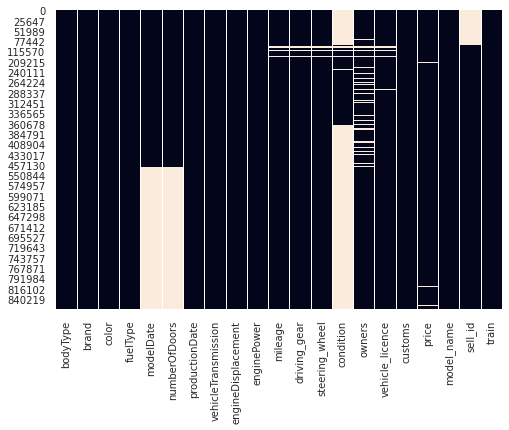

In [76]:
# Посмотрим теперь где поконкретнее пропуски в train порции.
sns.heatmap(comb_df[comb_df.train == 1].isna(), cbar=False);

Видим что в большом датасете за март ('train4') отсутствуют столбцы modelName, NumberOfDoors, condition. Также в датасете из baseline отсутствуют столбцы condition и sell_id. Ничего страшного, эти столбцы не являются основополагающими.

Теперь пройдемся по очереди по всем столбцам с пропусками в объединеном датасете comb_df и заполним пропуски

In [77]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733954 entries, 0 to 899011
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             733927 non-null  object 
 1   brand                733942 non-null  object 
 2   color                733942 non-null  object 
 3   fuelType             733933 non-null  object 
 4   modelDate            401280 non-null  float64
 5   numberOfDoors        401281 non-null  float64
 6   productionDate       733942 non-null  float64
 7   vehicleTransmission  733927 non-null  object 
 8   engineDisplacement   733931 non-null  float64
 9   enginePower          733931 non-null  float64
 10  mileage              726242 non-null  float64
 11  driving_gear         726227 non-null  object 
 12  steering_wheel       726241 non-null  object 
 13  condition            209682 non-null  object 
 14  owners               676423 non-null  float64
 15  vehicle_licence  

Сперва заметим что важный столбец price (наш таргет) имеет пропуски которые мы не в праве заполнить. Поэтому остается только удалить эти строки. Важно что test порция не имеет пропусков (мы заполнили соответствующие ячеки нулевыми значениями)

In [78]:
comb_df.dropna(subset=['price'], inplace=True)

In [79]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726935 entries, 0 to 899011
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             726921 non-null  object 
 1   brand                726935 non-null  object 
 2   color                726935 non-null  object 
 3   fuelType             726927 non-null  object 
 4   modelDate            396003 non-null  float64
 5   numberOfDoors        396003 non-null  float64
 6   productionDate       726935 non-null  float64
 7   vehicleTransmission  726921 non-null  object 
 8   engineDisplacement   726924 non-null  float64
 9   enginePower          726924 non-null  float64
 10  mileage              720216 non-null  float64
 11  driving_gear         720202 non-null  object 
 12  steering_wheel       720215 non-null  object 
 13  condition            205817 non-null  object 
 14  owners               670416 non-null  float64
 15  vehicle_licence  

In [80]:
#небольшое количество пропусков в столбце bodyType заполним наиболее популярным значением:
comb_df['bodyType'].fillna('внедорожник', inplace=True)

In [81]:
# Посмотрим на небольшое количество пропусков в столбце fuelType
comb_df[comb_df.fuelType.isna()]

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
111208,внедорожник,honda,пурпурный,NaN,NaN,NaN,1989.0,NaN,0.0,150.0,...,NaN,левый,Не требует ремонта,3.0,оригинал,1,110000.0,civic,1.096778e+09,1
575003,внедорожник,volkswagen,синий,NaN,NaN,NaN,1994.0,NaN,NaN,NaN,...,NaN,левый,NaN,3.0,оригинал,1,300000.0,transporter,1.096188e+09,1
664740,внедорожник,honda,серебристый,NaN,NaN,NaN,1989.0,NaN,NaN,NaN,...,NaN,левый,NaN,3.0,оригинал,1,120000.0,civic,1.097455e+09,1
677674,внедорожник,москвич,синий,NaN,NaN,NaN,1976.0,NaN,NaN,NaN,...,NaN,левый,NaN,1.0,оригинал,1,100000.0,430,1.102494e+09,1
760599,внедорожник,москвич,серый,NaN,NaN,NaN,1970.0,NaN,NaN,NaN,...,NaN,левый,NaN,3.0,оригинал,1,4025000.0,430,1.094124e+09,1
808172,внедорожник,honda,пурпурный,NaN,NaN,NaN,1989.0,NaN,NaN,NaN,...,NaN,левый,NaN,3.0,оригинал,1,110000.0,civic,1.096778e+09,1
827346,внедорожник,volkswagen,синий,NaN,NaN,NaN,2003.0,NaN,NaN,NaN,...,NaN,левый,NaN,2.0,оригинал,1,345000.0,sharan,1.096969e+09,1
844820,внедорожник,москвич,зелёный,NaN,NaN,NaN,1975.0,NaN,NaN,NaN,...,NaN,левый,NaN,1.0,оригинал,1,250000.0,430,1.090170e+09,1


Это бензиновые автомобили. Заполним пропуски значением 'бензин'

In [82]:
comb_df['fuelType'].fillna('бензин', inplace=True)

C modelDate проблема: много пропусков потому что датасет train4 не имел этого стобца. Вместо него был столбец generation (поколение модели) который однако перевести в год, когда то или иное поколение автомобилей было запущено в производство, весьма трудоемко. Заполним эти пропуски значениями из столбца productionDate.

In [83]:
comb_df['modelDate'].fillna(comb_df['productionDate'], inplace=True)

Количество дверей не является выжным параметром, заполним пропуски наиболее распространенным вариантом: 5 дверей

In [84]:
comb_df['numberOfDoors'].fillna(5, inplace=True)

In [85]:
# Посмотрим на небольшое количество пропусков в столбце vehicleTransmission
comb_df[comb_df.vehicleTransmission.isna()]

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
24624,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,NaN,NaN,NaN,...,NaN,левый,NaN,3.0,оригинал,1,120000.0,civic,NaN,1
111208,внедорожник,honda,пурпурный,бензин,1989.0,5.0,1989.0,NaN,0.0,150.0,...,NaN,левый,Не требует ремонта,3.0,оригинал,1,110000.0,civic,1.096778e+09,1
276542,внедорожник,toyota,серебристый,бензин,2008.0,5.0,2008.0,NaN,NaN,NaN,...,NaN,правый,True,3.0,оригинал,1,690000.0,noah,1.092703e+09,1
313670,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,NaN,NaN,NaN,...,NaN,левый,True,3.0,оригинал,1,120000.0,civic,1.097455e+09,1
314045,внедорожник,honda,пурпурный,бензин,1989.0,5.0,1989.0,NaN,NaN,NaN,...,NaN,левый,True,3.0,оригинал,1,110000.0,civic,1.096778e+09,1
417715,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,NaN,0.0,150.0,...,NaN,левый,NaN,3.0,оригинал,0,120000.0,civic,1.097455e+09,1
446990,внедорожник,honda,пурпурный,бензин,1989.0,5.0,1989.0,NaN,0.0,150.0,...,NaN,левый,NaN,3.0,оригинал,0,110000.0,civic,1.096778e+09,1
575003,внедорожник,volkswagen,синий,бензин,1994.0,5.0,1994.0,NaN,NaN,NaN,...,NaN,левый,NaN,3.0,оригинал,1,300000.0,transporter,1.096188e+09,1
664740,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,NaN,NaN,NaN,...,NaN,левый,NaN,3.0,оригинал,1,120000.0,civic,1.097455e+09,1
677674,внедорожник,москвич,синий,бензин,1976.0,5.0,1976.0,NaN,NaN,NaN,...,NaN,левый,NaN,1.0,оригинал,1,100000.0,430,1.102494e+09,1


Это в основном старые автомобили поэтому заполним пропуски как 'механическая'

In [86]:
comb_df.vehicleTransmission.fillna('механическая', inplace = True)

In [87]:
# Посмотрим на небольшое количество пропусков в столбце engineDisplacement
comb_df[comb_df.engineDisplacement.isna()]

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
24624,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,механическая,NaN,NaN,...,NaN,левый,NaN,3.0,оригинал,1,120000.0,civic,NaN,1
276542,внедорожник,toyota,серебристый,бензин,2008.0,5.0,2008.0,механическая,NaN,NaN,...,NaN,правый,True,3.0,оригинал,1,690000.0,noah,1.092703e+09,1
313670,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,механическая,NaN,NaN,...,NaN,левый,True,3.0,оригинал,1,120000.0,civic,1.097455e+09,1
314045,внедорожник,honda,пурпурный,бензин,1989.0,5.0,1989.0,механическая,NaN,NaN,...,NaN,левый,True,3.0,оригинал,1,110000.0,civic,1.096778e+09,1
575003,внедорожник,volkswagen,синий,бензин,1994.0,5.0,1994.0,механическая,NaN,NaN,...,NaN,левый,NaN,3.0,оригинал,1,300000.0,transporter,1.096188e+09,1
664740,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,механическая,NaN,NaN,...,NaN,левый,NaN,3.0,оригинал,1,120000.0,civic,1.097455e+09,1
677674,внедорожник,москвич,синий,бензин,1976.0,5.0,1976.0,механическая,NaN,NaN,...,NaN,левый,NaN,1.0,оригинал,1,100000.0,430,1.102494e+09,1
760599,внедорожник,москвич,серый,бензин,1970.0,5.0,1970.0,механическая,NaN,NaN,...,NaN,левый,NaN,3.0,оригинал,1,4025000.0,430,1.094124e+09,1
808172,внедорожник,honda,пурпурный,бензин,1989.0,5.0,1989.0,механическая,NaN,NaN,...,NaN,левый,NaN,3.0,оригинал,1,110000.0,civic,1.096778e+09,1
827346,внедорожник,volkswagen,синий,бензин,2003.0,5.0,2003.0,механическая,NaN,NaN,...,NaN,левый,NaN,2.0,оригинал,1,345000.0,sharan,1.096969e+09,1


Это малолитражки (Honds Civic, москвич), заполним объем двигателя как 1.6

In [88]:
comb_df.engineDisplacement.fillna(1.6, inplace=True)

In [89]:
# Посмотрим на небольшое количество пропусков в столбце enginePower
comb_df[comb_df.enginePower.isna()]

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
24624,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,механическая,1.6,NaN,...,NaN,левый,NaN,3.0,оригинал,1,120000.0,civic,NaN,1
276542,внедорожник,toyota,серебристый,бензин,2008.0,5.0,2008.0,механическая,1.6,NaN,...,NaN,правый,True,3.0,оригинал,1,690000.0,noah,1.092703e+09,1
313670,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,механическая,1.6,NaN,...,NaN,левый,True,3.0,оригинал,1,120000.0,civic,1.097455e+09,1
314045,внедорожник,honda,пурпурный,бензин,1989.0,5.0,1989.0,механическая,1.6,NaN,...,NaN,левый,True,3.0,оригинал,1,110000.0,civic,1.096778e+09,1
575003,внедорожник,volkswagen,синий,бензин,1994.0,5.0,1994.0,механическая,1.6,NaN,...,NaN,левый,NaN,3.0,оригинал,1,300000.0,transporter,1.096188e+09,1
664740,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,механическая,1.6,NaN,...,NaN,левый,NaN,3.0,оригинал,1,120000.0,civic,1.097455e+09,1
677674,внедорожник,москвич,синий,бензин,1976.0,5.0,1976.0,механическая,1.6,NaN,...,NaN,левый,NaN,1.0,оригинал,1,100000.0,430,1.102494e+09,1
760599,внедорожник,москвич,серый,бензин,1970.0,5.0,1970.0,механическая,1.6,NaN,...,NaN,левый,NaN,3.0,оригинал,1,4025000.0,430,1.094124e+09,1
808172,внедорожник,honda,пурпурный,бензин,1989.0,5.0,1989.0,механическая,1.6,NaN,...,NaN,левый,NaN,3.0,оригинал,1,110000.0,civic,1.096778e+09,1
827346,внедорожник,volkswagen,синий,бензин,2003.0,5.0,2003.0,механическая,1.6,NaN,...,NaN,левый,NaN,2.0,оригинал,1,345000.0,sharan,1.096969e+09,1


Тот же самый список малолитражек, заполним как 100 л.с.

In [90]:
comb_df.enginePower.fillna(100, inplace=True)

In [91]:
# Посмотрим что за пропуски в столбце milage (пробег) и какого года выпуска эти автомобили
display(comb_df[comb_df.mileage.isna()])
comb_df[comb_df.mileage.isna()].productionDate.value_counts()

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
89380,лифтбек,skoda,белый,бензин,2020.0,5.0,2021.0,механическая,1.6,90.0,...,NaN,NaN,NaN,NaN,NaN,0,1464100.0,skoda,1.104778e+09,1
89382,внедорожник,skoda,серый,бензин,2017.0,5.0,2021.0,автоматическая,1.4,150.0,...,NaN,NaN,NaN,NaN,NaN,0,2653190.0,skoda,1.105298e+09,1
89387,внедорожник,skoda,белый,бензин,2017.0,5.0,2021.0,автоматическая,1.4,150.0,...,NaN,NaN,NaN,NaN,NaN,0,2788433.0,skoda,1.105388e+09,1
89389,внедорожник,skoda,синий,бензин,2017.0,5.0,2021.0,автоматическая,1.4,150.0,...,NaN,NaN,NaN,NaN,NaN,0,2808125.0,skoda,1.105064e+09,1
89394,внедорожник,skoda,бежевый,бензин,2017.0,5.0,2021.0,автоматическая,1.4,150.0,...,NaN,NaN,NaN,NaN,NaN,0,2638230.0,skoda,1.105388e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216085,внедорожник,mitsubishi,белый,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,NaN,NaN,NaN,NaN,NaN,0,1934675.0,mitsubishi,1.104685e+09,1
216663,внедорожник,mitsubishi,чёрный,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,NaN,NaN,NaN,NaN,NaN,0,2510000.0,mitsubishi,1.103457e+09,1
216899,внедорожник,mitsubishi,синий,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,NaN,NaN,NaN,NaN,NaN,0,2052000.0,mitsubishi,1.103297e+09,1
217681,внедорожник,mitsubishi,серебристый,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,NaN,NaN,NaN,NaN,NaN,0,1928500.0,mitsubishi,1.103297e+09,1


2021.0    6638
2020.0      70
2019.0      11
Name: productionDate, dtype: int64

По всей видимости это новые aвтомобили. Пустые значения столбца mileage (пробег) заполним 0

In [92]:
comb_df.mileage.fillna(0, inplace=True)

In [93]:
# Посмотрим что за пропуски в столбце driving_gear и какого типа эти автомобили
display(comb_df[comb_df.driving_gear.isna()])
comb_df[comb_df.driving_gear.isna()].bodyType.value_counts()

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
24624,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,механическая,1.6,100.0,...,NaN,левый,NaN,3.0,оригинал,1,120000.0,civic,NaN,1
89380,лифтбек,skoda,белый,бензин,2020.0,5.0,2021.0,механическая,1.6,90.0,...,NaN,NaN,NaN,NaN,NaN,0,1464100.0,skoda,1.104778e+09,1
89382,внедорожник,skoda,серый,бензин,2017.0,5.0,2021.0,автоматическая,1.4,150.0,...,NaN,NaN,NaN,NaN,NaN,0,2653190.0,skoda,1.105298e+09,1
89387,внедорожник,skoda,белый,бензин,2017.0,5.0,2021.0,автоматическая,1.4,150.0,...,NaN,NaN,NaN,NaN,NaN,0,2788433.0,skoda,1.105388e+09,1
89389,внедорожник,skoda,синий,бензин,2017.0,5.0,2021.0,автоматическая,1.4,150.0,...,NaN,NaN,NaN,NaN,NaN,0,2808125.0,skoda,1.105064e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677674,внедорожник,москвич,синий,бензин,1976.0,5.0,1976.0,механическая,1.6,100.0,...,NaN,левый,NaN,1.0,оригинал,1,100000.0,430,1.102494e+09,1
760599,внедорожник,москвич,серый,бензин,1970.0,5.0,1970.0,механическая,1.6,100.0,...,NaN,левый,NaN,3.0,оригинал,1,4025000.0,430,1.094124e+09,1
808172,внедорожник,honda,пурпурный,бензин,1989.0,5.0,1989.0,механическая,1.6,100.0,...,NaN,левый,NaN,3.0,оригинал,1,110000.0,civic,1.096778e+09,1
827346,внедорожник,volkswagen,синий,бензин,2003.0,5.0,2003.0,механическая,1.6,100.0,...,NaN,левый,NaN,2.0,оригинал,1,345000.0,sharan,1.096969e+09,1


внедорожник    4869
седан          1011
лифтбек         750
минивэн          49
купе             22
хэтчбек          13
универсал        12
пикап             5
фургон            1
родстер           1
Name: bodyType, dtype: int64

Видим что полно внедорожников поэтому заполним пропуски как 'полный' привод

In [94]:
comb_df.driving_gear.fillna('полный', inplace=True)

Пропуски в steering_wheel заполним как 'левый'

In [95]:
comb_df.steering_wheel.fillna('левый', inplace=True)

Столбец condition бинарен, заполним значениями 1 если указано что ремонта не требуетсяб иначе 0

In [96]:
comb_df.condition = comb_df.condition.apply(lambda x: 1 if x == 'Не требует ремонта' else 0)

In [97]:
# Посмотрим что за пропуски в столбце owner и какого года выпуска эти автомобили
display(comb_df[comb_df.owners.isna()])
comb_df[comb_df.owners.isna()].productionDate.value_counts()

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
332,седан,audi,серый,бензин,2016.0,4.0,2020.0,роботизированная,1.4,150.0,...,передний,левый,0,NaN,оригинал,1,1885400.0,a3,NaN,1
333,седан,audi,серебристый,бензин,2016.0,4.0,2020.0,роботизированная,1.4,150.0,...,передний,левый,0,NaN,оригинал,1,1885400.0,a3,NaN,1
336,седан,audi,синий,бензин,2016.0,4.0,2020.0,роботизированная,1.4,150.0,...,передний,левый,0,NaN,оригинал,1,1885400.0,a3,NaN,1
339,седан,audi,синий,бензин,2016.0,4.0,2020.0,роботизированная,1.4,150.0,...,передний,левый,0,NaN,оригинал,1,2016000.0,a3,NaN,1
342,седан,audi,серый,бензин,2016.0,4.0,2020.0,роботизированная,1.4,150.0,...,передний,левый,0,NaN,оригинал,1,1946000.0,a3,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821835,седан,lada (ваз),серебристый,бензин,2008.0,5.0,2008.0,механическая,1.6,81.0,...,передний,левый,0,NaN,оригинал,1,99000.0,2115,1.032575e+09,1
827929,седан,lada (ваз),чёрный,бензин,2006.0,5.0,2006.0,механическая,1.6,90.0,...,передний,левый,0,NaN,оригинал,1,97000.0,2110,1.023100e+09,1
831508,универсал,chrysler,красный,бензин,2007.0,5.0,2007.0,механическая,1.6,115.0,...,передний,левый,0,NaN,оригинал,1,360000.0,pt,1.038449e+09,1
845142,седан,mazda,фиолетовый,бензин,2006.0,5.0,2006.0,механическая,2.0,147.0,...,передний,левый,0,NaN,оригинал,1,380000.0,6,1.051686e+09,1


2021.0    44755
2020.0    10854
2019.0      807
2018.0       67
2008.0        3
2006.0        3
2007.0        3
2011.0        3
1980.0        3
2001.0        2
1995.0        2
2000.0        2
1994.0        1
1993.0        1
1989.0        1
1996.0        1
1997.0        1
2005.0        1
2002.0        1
2003.0        1
2004.0        1
2010.0        1
2012.0        1
2013.0        1
2015.0        1
2017.0        1
1962.0        1
Name: productionDate, dtype: int64

Видим что это в подавляющем большинстве новые автомобили поэтому заполним пропуски нолями

In [98]:
comb_df.owners.fillna(0, inplace=True)

In [99]:
# Посмотрим что за пропуски в столбце vehicle_licence и сколько хозяев было у автомобилей
display(comb_df[comb_df.vehicle_licence.isna()])
comb_df[comb_df.vehicle_licence.isna()].owners.value_counts()

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
639,седан,audi,синий,бензин,2016.0,4.0,2020.0,роботизированная,1.4,150.0,...,передний,левый,0,0.0,NaN,1,2050000.0,a3,NaN,1
1575,седан,audi,серебристый,бензин,2018.0,4.0,2020.0,роботизированная,0.0,190.0,...,передний,левый,0,0.0,NaN,1,3089848.0,a6,NaN,1
1579,седан,audi,чёрный,бензин,2018.0,4.0,2020.0,роботизированная,0.0,190.0,...,передний,левый,0,0.0,NaN,1,3089848.0,a6,NaN,1
1590,седан,audi,белый,бензин,2018.0,4.0,2020.0,роботизированная,0.0,190.0,...,передний,левый,0,0.0,NaN,1,3089848.0,a6,NaN,1
2273,седан,audi,чёрный,бензин,2018.0,4.0,2020.0,роботизированная,0.0,245.0,...,полный,левый,0,0.0,NaN,1,4435000.0,a6,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836920,универсал,opel,серебристый,дизель,2007.0,5.0,2007.0,механическая,1.3,90.0,...,передний,левый,0,3.0,NaN,1,280000.0,astra,1.053064e+09,1
841843,хэтчбек,lada (ваз),серый,бензин,2005.0,5.0,2005.0,механическая,1.5,77.0,...,передний,левый,0,3.0,NaN,1,135000.0,2114,4.734215e+07,1
844496,универсал,opel,серый,бензин,2009.0,5.0,2009.0,автоматическая,2.0,220.0,...,полный,левый,0,1.0,NaN,1,895000.0,insignia,1.613033e+07,1
854628,хэтчбек,opel,золотистый,бензин,2007.0,5.0,2007.0,механическая,1.2,80.0,...,передний,левый,0,2.0,NaN,1,453232.0,corsa,1.012104e+09,1


0.0    9910
2.0       9
3.0       9
1.0       5
Name: owners, dtype: int64

Это же в подавляющем большинстве те новые автомобили для которых мы заполниои 0 хозяев. Поэтому заполним пропуски как 'оригинал'

In [100]:
comb_df.vehicle_licence.fillna('оригинал', inplace=True)

In [101]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726935 entries, 0 to 899011
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             726935 non-null  object 
 1   brand                726935 non-null  object 
 2   color                726935 non-null  object 
 3   fuelType             726935 non-null  object 
 4   modelDate            726935 non-null  float64
 5   numberOfDoors        726935 non-null  float64
 6   productionDate       726935 non-null  float64
 7   vehicleTransmission  726935 non-null  object 
 8   engineDisplacement   726935 non-null  float64
 9   enginePower          726935 non-null  float64
 10  mileage              726935 non-null  float64
 11  driving_gear         726935 non-null  object 
 12  steering_wheel       726935 non-null  object 
 13  condition            726935 non-null  int64  
 14  owners               726935 non-null  float64
 15  vehicle_licence  

Столбец sell_id в модель подавать не будем но и удалять его не будем потому что он нужен для сабмита. В общем-то этого столбца в трейне вовсе не должно быть

### 3.4. EDA

In [102]:
# Посмотрим количество уникальных значений в каждом столбце
comb_df.nunique(dropna=False)

bodyType                   20
brand                     175
color                      16
fuelType                    9
modelDate                  97
numberOfDoors               5
productionDate             97
vehicleTransmission         4
engineDisplacement         79
enginePower               475
mileage                106217
driving_gear                3
steering_wheel              2
condition                   2
owners                      5
vehicle_licence             2
customs                     2
price                   34250
model_name               2060
sell_id                549083
train                       2
dtype: int64

In [103]:
# Сгруппируем признаки по типам
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate']
bin_cols = ['condition', 'customs', 'steering_wheel', 'vehicle_licence']
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'model_name', 'driving_gear', 'owners', 'numberOfDoors']
target_cols = ['price']

#### 3.4.1. Анализ числовые признаков

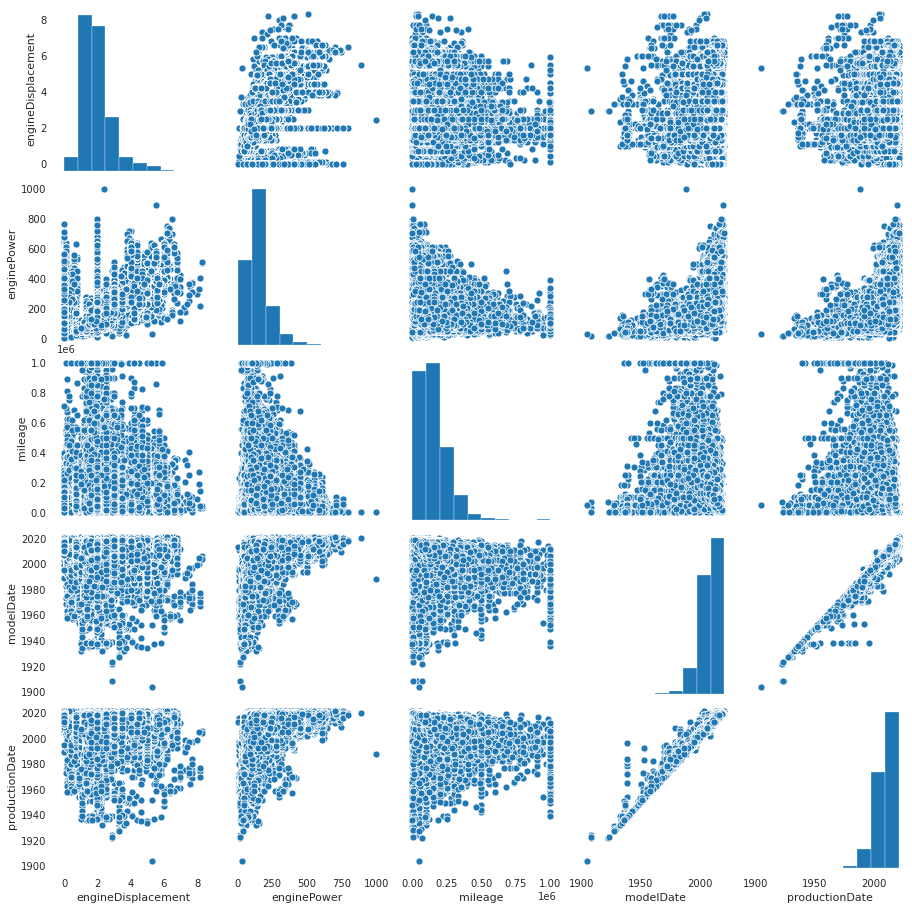

In [104]:
# посмотрим на корреляцию числовых признаков
sns.pairplot(comb_df[num_cols])

Видим сильную корреляцию между modelDate и productionDate что ожидаемо. Есть несколько других закомерностей, например, engine power и productionDate. Есть выбросы.

In [105]:
# Посмотрим на общую информацию
comb_df[num_cols].describe()

,engineDisplacement,enginePower,mileage,modelDate,productionDate
count,726935.000000,726935.000000,726935.000000,726935.000000,726935.000000
mean,2.022700,155.824540,143365.779592,2008.337671,2009.558641
std,0.840298,79.333711,103469.705852,8.436816,8.363386
min,0.000000,7.000000,0.000000,1904.000000,1904.000000
25%,1.600000,105.000000,69124.000000,2004.000000,2006.000000
50%,1.800000,140.000000,133000.000000,2010.000000,2011.000000
75%,2.300000,184.000000,200000.000000,2014.000000,2016.000000
max,8.300000,1000.000000,1000000.000000,2021.000000,2021.000000


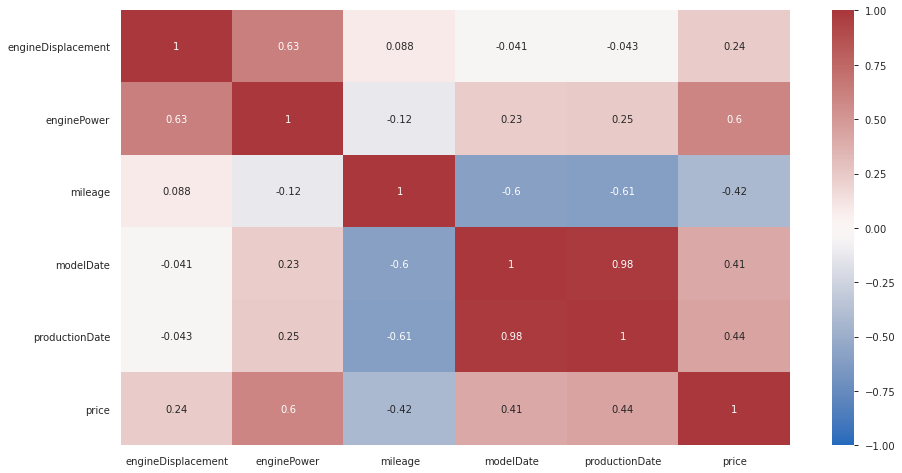

In [106]:
# Посмотрим на корреляцию числовых признаков с ценой (нашим таргетом)
plt.figure(figsize=(15, 8));
sns.heatmap(comb_df[comb_df.train == 1][num_cols + ['price']].corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')

Видим что все признаки сильно влияют на цену за исключением engineDisplacement который в свою очередь тесно связан с enginePower. Также modelDate и productionDate показывают сильную взаимосвязь. Удалим engineDisplacement и modelDate

In [107]:
comb_df.drop(['modelDate', 'engineDisplacement'], axis=1, inplace=True)
for col in ['modelDate', 'engineDisplacement']:
    num_cols.remove(col)

#### 3.4.2. Анализ бинарных и категоральных признаков

Посмотрим есть ли дисбаланс между трейновой и тестовой выборками

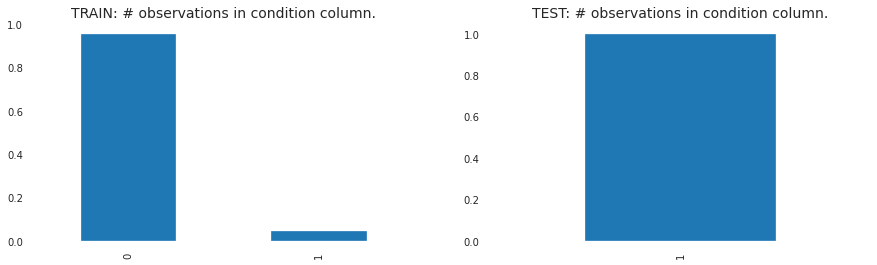

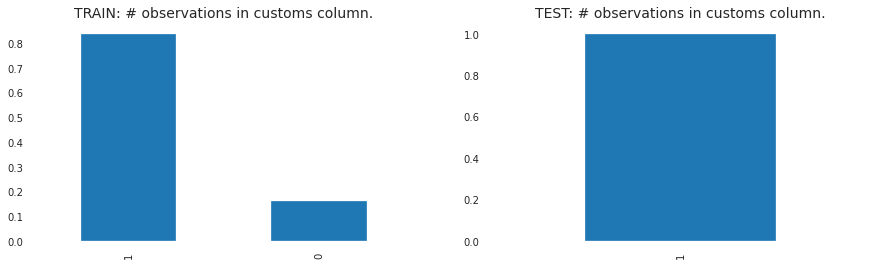

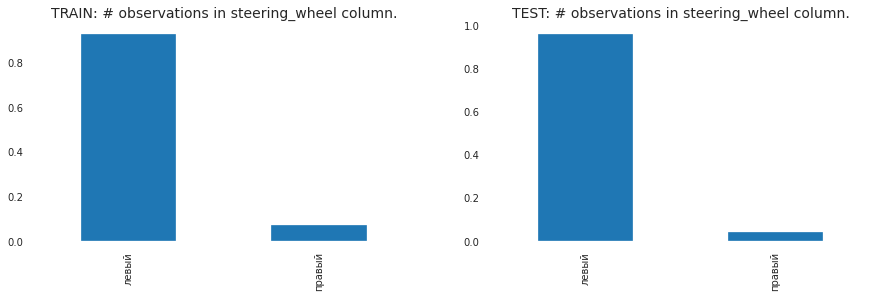

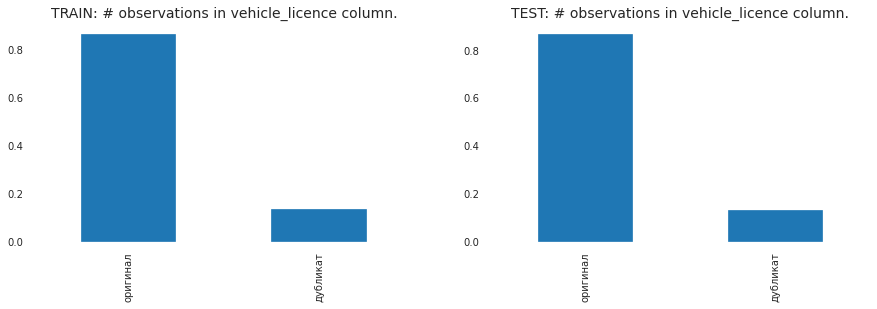

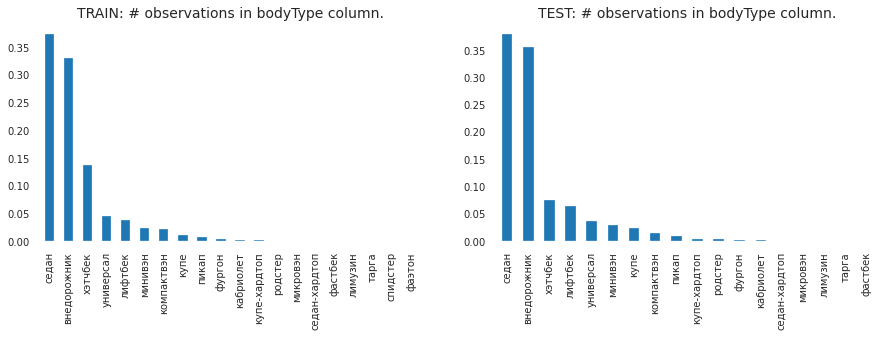

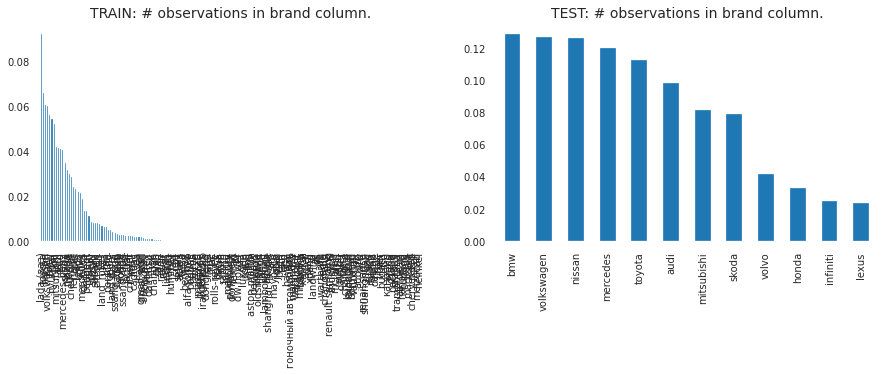

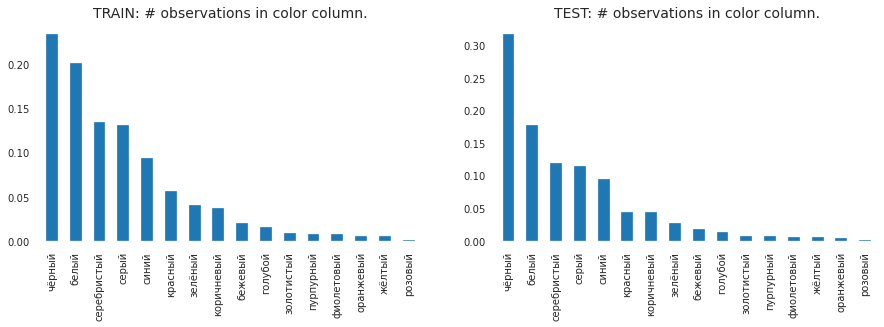

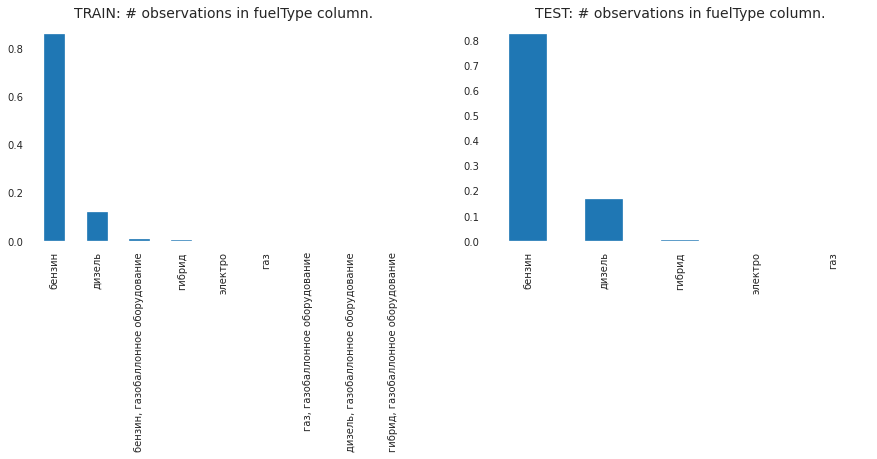

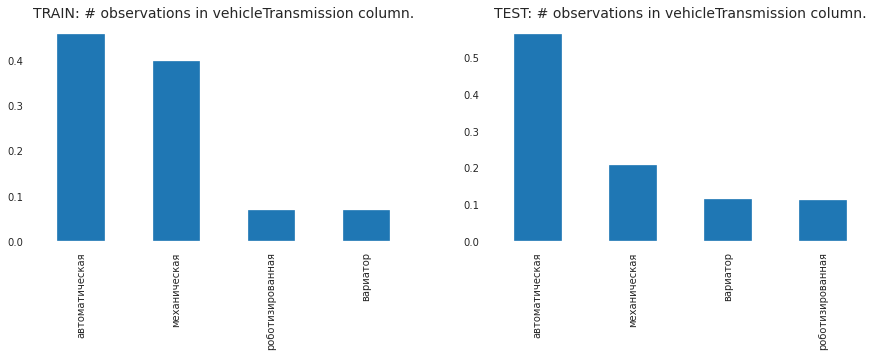

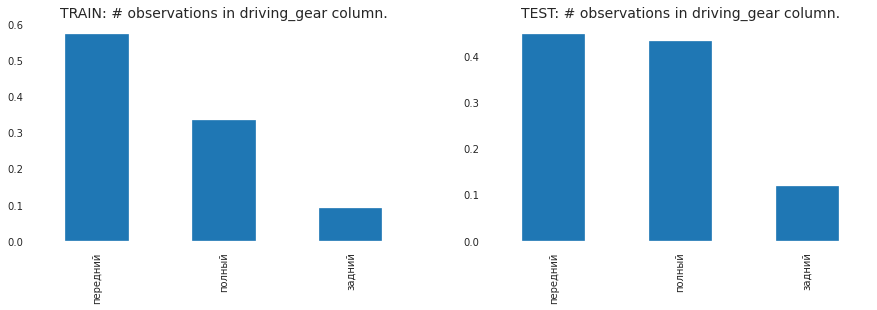

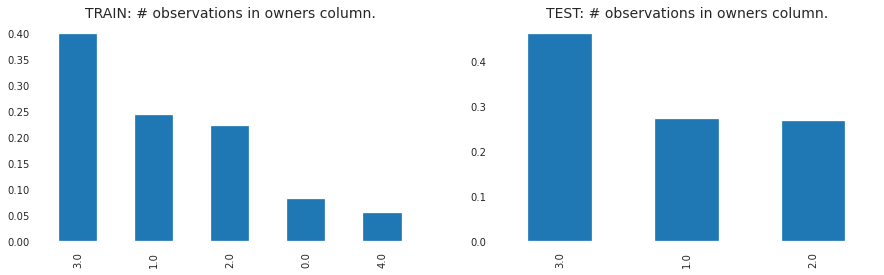

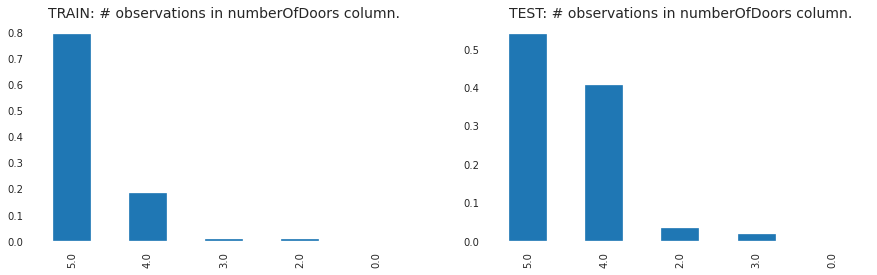

In [108]:
for col in (bin_cols + cat_cols):
    if col not in ['model_name']:
        fig, ax = plt.subplots(figsize=(15, 4), ncols=2, nrows=1)
        ax[0].set_title(f'TRAIN: # observations in {col} column.', fontdict={'fontsize': 14})
        comb_df[comb_df.train == 1][col].value_counts(normalize=True).plot(kind='bar', ax=ax[0])
        ax[1].set_title(f'TEST: # observations in {col} column.', fontdict={'fontsize': 14})
        comb_df[comb_df.train == 0][col].value_counts(normalize=True).plot(kind='bar', ax=ax[1])

Видно что есть сужественные перекосы. В общем говоря, тестовая выборка ограничена. Трейновая выборка гораздо шире. Если конкретнее, то столбцы condition и custom не являются бинарными в тестовой выборке (все строки имеют значения "не требует ремонта" и "растаможен"). Также тестовая выборка содержит лишь 12 марок (brands) и меньше категоральных значений в столбцах fuelType и owners. 
**Удалим лишнее и приведём трейновую часть в соответствие с тестовой. Тут надо чётко понимать что мы это делаем для того чтобы не перегружать моделирование и для улучшения точности предсказания для нашей конкретной тестовой части. В обшем случае мы бы этого не делали.**

In [109]:
comb_df = comb_df[comb_df.brand.isin(comb_df[comb_df.train == 0].brand.unique())]

In [110]:
comb_df = comb_df[comb_df.fuelType.isin(comb_df[comb_df.train == 0].fuelType.unique())]

In [111]:
comb_df = comb_df[comb_df.owners.isin(comb_df[comb_df.train == 0].owners.unique())]

In [112]:
comb_df.drop(['condition', 'customs'], axis=1, inplace=True)
for col in ['condition', 'customs']:
    bin_cols.remove(col)
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297530 entries, 0 to 899011
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             297530 non-null  object 
 1   brand                297530 non-null  object 
 2   color                297530 non-null  object 
 3   fuelType             297530 non-null  object 
 4   numberOfDoors        297530 non-null  float64
 5   productionDate       297530 non-null  float64
 6   vehicleTransmission  297530 non-null  object 
 7   enginePower          297530 non-null  float64
 8   mileage              297530 non-null  float64
 9   driving_gear         297530 non-null  object 
 10  steering_wheel       297530 non-null  object 
 11  owners               297530 non-null  float64
 12  vehicle_licence      297530 non-null  object 
 13  price                297530 non-null  float64
 14  model_name           297530 non-null  object 
 15  sell_id          

Видим что в итоге мы срезали более половины записей, но что делать... За-то подстроились под тестовый датасет. Проверим как оно теперь

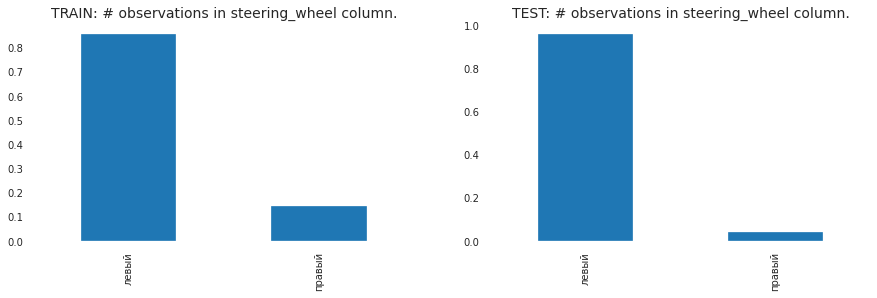

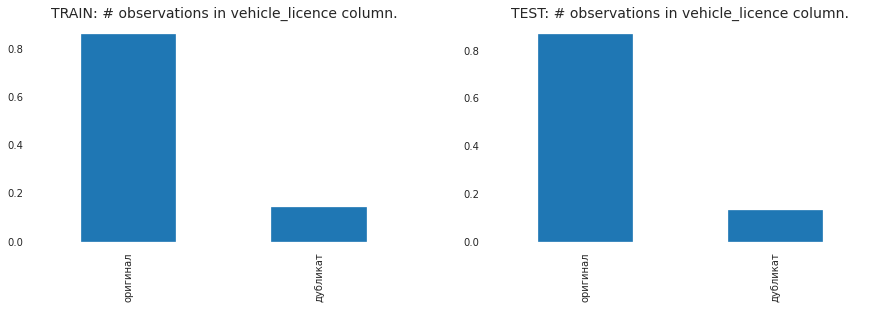

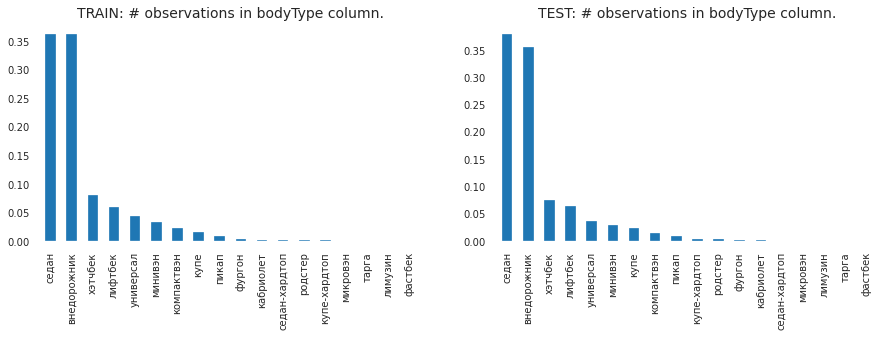

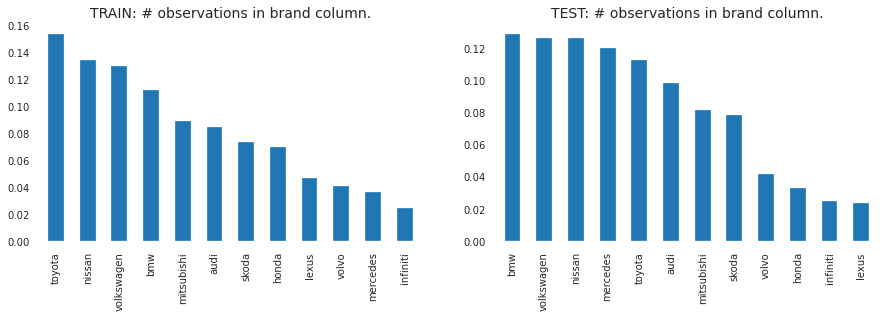

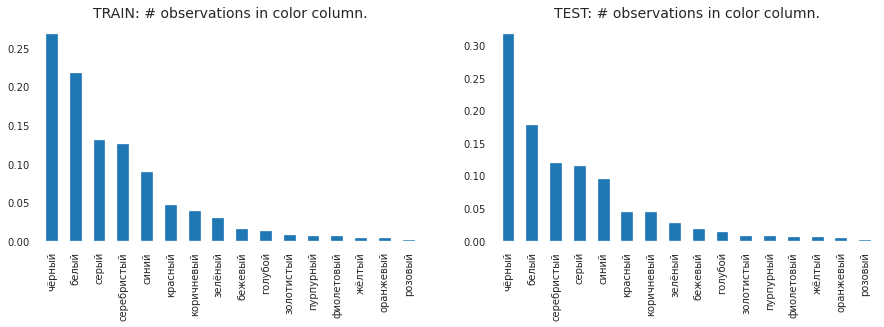

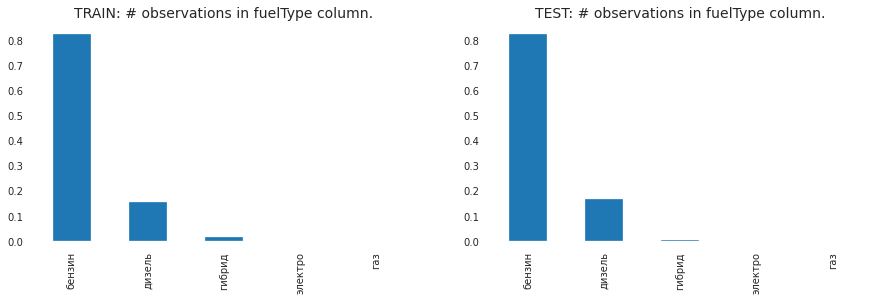

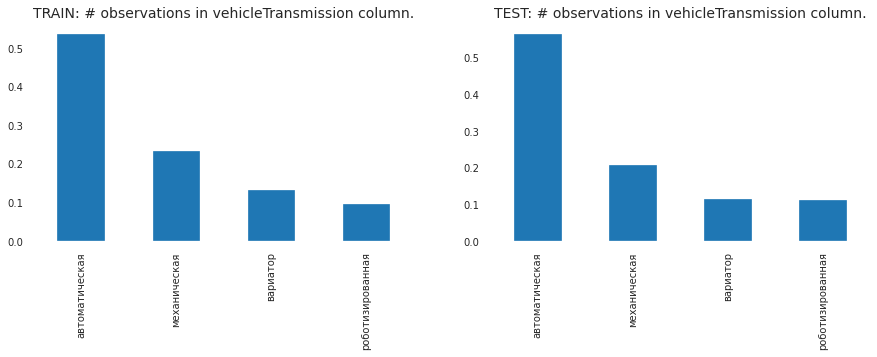

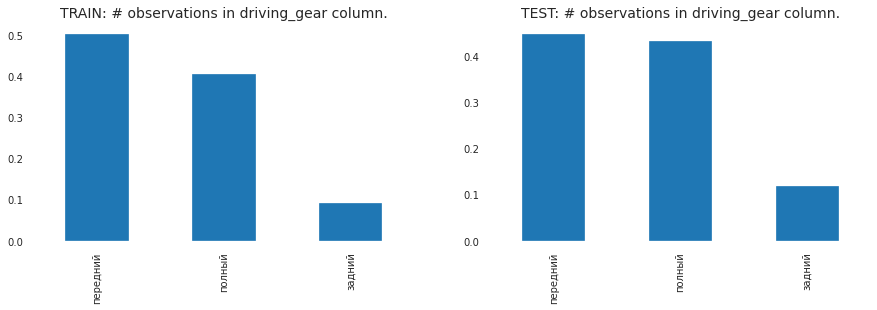

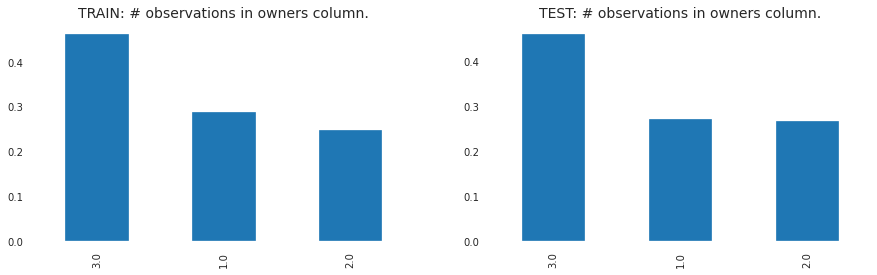

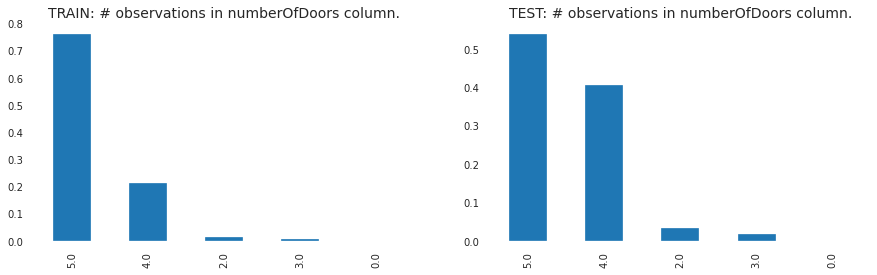

In [113]:
for col in (bin_cols + cat_cols):
    if col not in ['model_name']:
        fig, ax = plt.subplots(figsize=(15, 4), ncols=2, nrows=1)
        ax[0].set_title(f'TRAIN: # observations in {col} column.', fontdict={'fontsize': 14})
        comb_df[comb_df.train == 1][col].value_counts(normalize=True).plot(kind='bar', ax=ax[0])
        ax[1].set_title(f'TEST: # observations in {col} column.', fontdict={'fontsize': 14})
        comb_df[comb_df.train == 0][col].value_counts(normalize=True).plot(kind='bar', ax=ax[1])

Здорово! Соотвествие весьма неплохое!

#### 3.4.3. Анализ таргета (price)

Text(0.5, 0, 'price, RUB * 10^7')

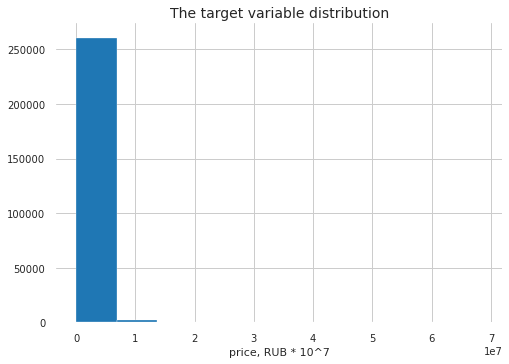

In [114]:
# посмотрим на таргет (price)
comb_df.query('train == 1').price.hist();
plt.title('The target variable distribution', fontdict={'fontsize': 14});
plt.xlabel('price, RUB * 10^7')

Большой хвост по цене, поэтому прологорифмируем наш таргет и добавим его как новый столбец

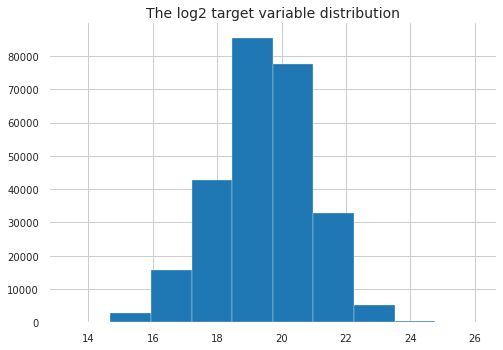

In [115]:
np.log2(comb_df.query('train == 1').price).hist();
plt.title('The log2 target variable distribution', fontdict={'fontsize': 14});
comb_df['price_log2'] = np.log2(comb_df.price + 1)

#### 3.4.4. Выбросы

Среднее значение enginePower = 175.203
Среднее значение mileage = 164758.292
Среднее значение productionDate = 2008.829


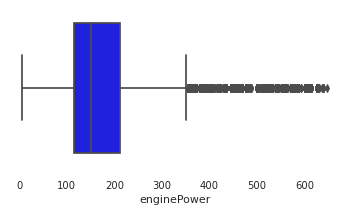

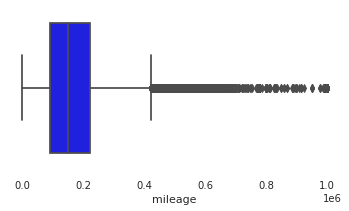

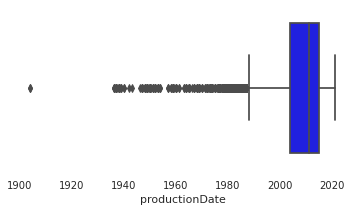

In [116]:
# Посмотрим на выбросы в числовых признаках:

def outliers_iqr(col): #Избавление числового признака от выбросов
        quartile_1, quartile_3 = np.percentile(list(col), [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        return comb_df[col < upper_bound][col > lower_bound]
    
def plot_boxplots(features): # Построение boxpots
    for feature in features:
        plt.figure(figsize=(6,3))
        sns.boxplot(features[feature], color = 'blue')
        print('Среднее значение {} = {:.3f}'.format(feature, features[feature].mean()))
    
    
plot_boxplots(comb_df[num_cols])
    



То что определяется как выбросы на самом деле похоже на реальные данные данные: ведь есть же автомобили с мощьностью более 350 л.с., автомобили с пробегом более пол миллиона км и раритетные автомобили. Поэтому решено "выбросы" не удалять.

#### 3.4.5. Feature Engineering

In [117]:
print(num_cols)

['enginePower', 'mileage', 'productionDate']


Среди трёч числовых признаков лишь productionDate вызывает ворос. Лучше использовать возраст автомобиля вместо года производства. Также создадим новый признак: средний годовой пробег.

In [118]:
comb_df['age'] = 2021 - comb_df.productionDate
comb_df['mileage_per_year'] = round(comb_df['mileage'] / comb_df['age'], 0)
num_cols = num_cols+['age','mileage_per_year']
num_cols.remove('productionDate')
comb_df.drop(['productionDate'], axis=1, inplace=True)

Также создадим следующие новые признаки:

1) столбец обозначающий старые автомобили (старше 10 лет) так как цена на них не сильно зависит от возраста

2) столбец обозначающий редкие цвета так как это чвсто дорогие автомобили

3) автомобили с редкими типами кузова которые могут обозначать высокую цену

Признаки эти бинарны

In [119]:
comb_df['old_car'] = comb_df.age.apply(lambda x: 1 if x >10 else 0)
comb_df['rare_colors'] = comb_df.color.apply(lambda x: 1 if x in ['фиолетовый', 'пурпурный', 'золотистый', 'оранжевый', 'жёлтый', 'розовый'] else 0)
comb_df['rare_bodyType'] = comb_df.bodyType.apply(lambda x: 1 if x in ['микровэн', 'седан-хардтоп', 'лимузин', 'тарга', 'фастбек'] else 0)
bin_cols = bin_cols+['old_car','rare_colors','rare_bodyType']

In [120]:
# Прологорифмируем числовые признаки
comb_df['enginePower_log2'] = np.log2(comb_df.enginePower+1)
comb_df['enginePower_log2'].replace([np.inf, -np.inf], 0, inplace=True)
comb_df['mileage_log2'] = np.log2(comb_df.mileage+1)
comb_df['mileage_log2'].replace([np.inf, -np.inf], 0, inplace=True)
comb_df['age_log2'] = np.log2(comb_df.age+1)
comb_df['age_log2'].replace([np.inf, -np.inf], 0, inplace=True)
comb_df['mileage_per_year_log2'] = np.log2(comb_df.mileage_per_year+1)
comb_df['mileage_per_year_log2'].replace([np.inf, -np.inf], 0, inplace=True)
# Удалим старые слолбцы
comb_df.drop(['enginePower','mileage','age','mileage_per_year'], axis=1, inplace=True)
num_cols = ['enginePower_log2', 'mileage_log2', 'age_log2', 'mileage_per_year_log2']

**Анализ обновлённых признаков**

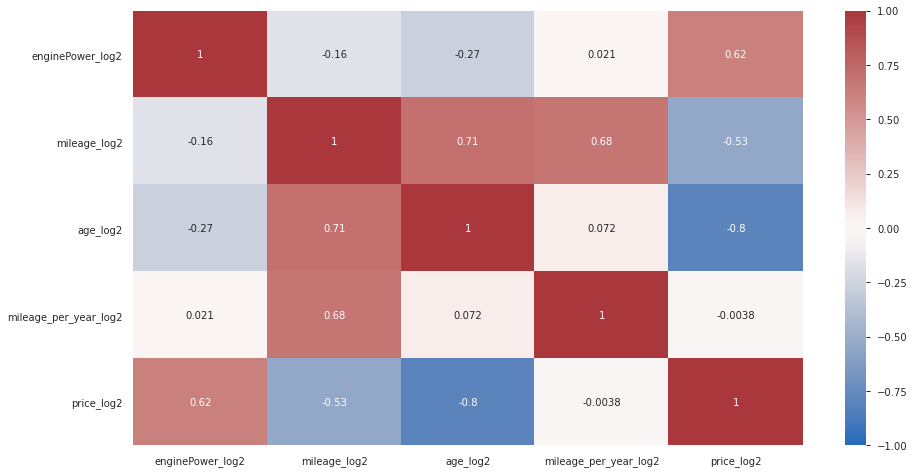

In [121]:
# Посмотрим на корреляцию новых числовых параметров с ценой (нашим таргетом)
plt.figure(figsize=(15, 8));
sns.heatmap(comb_df[comb_df.train == 1][num_cols + ['price_log2']].corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')

Заметим что стало получше чем было. Сгенерированый признак mileage_per_year_log2 слабоват но всё же...

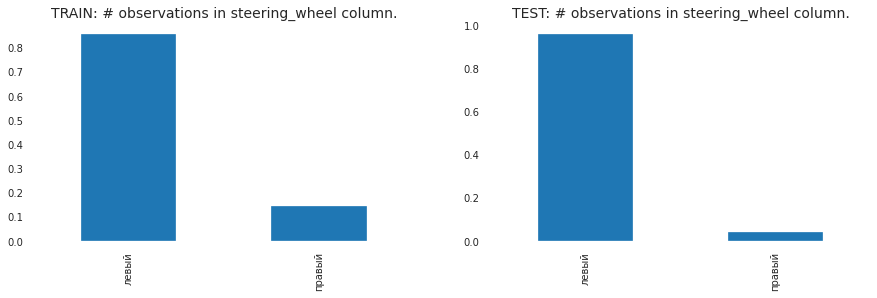

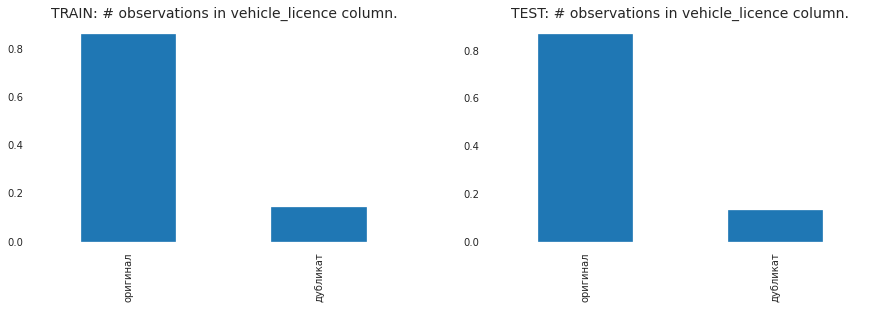

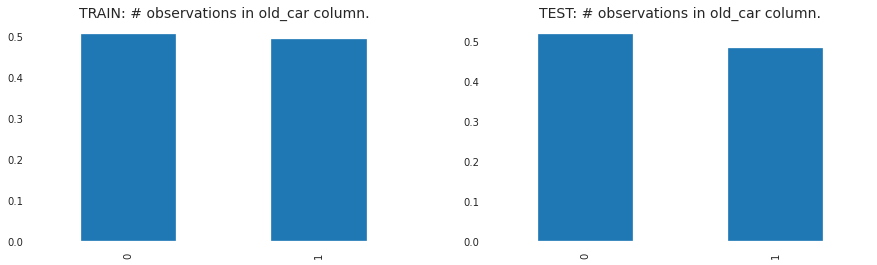

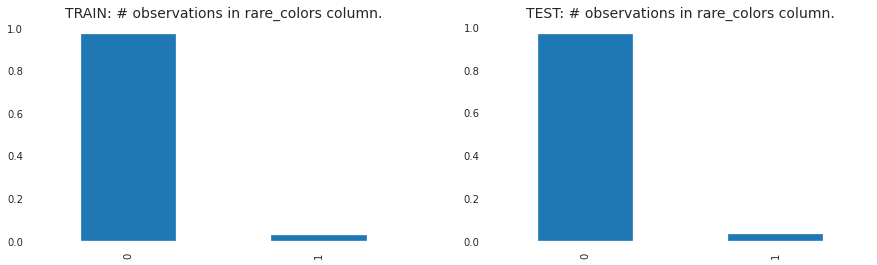

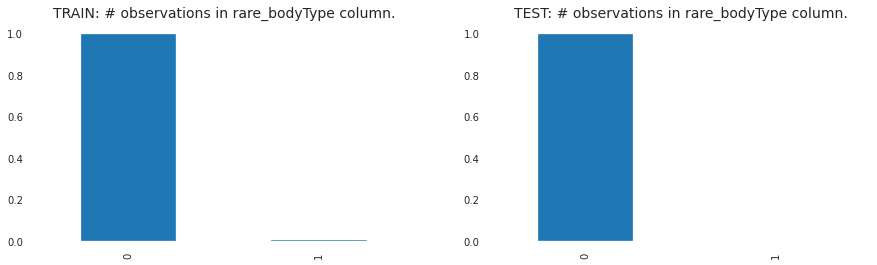

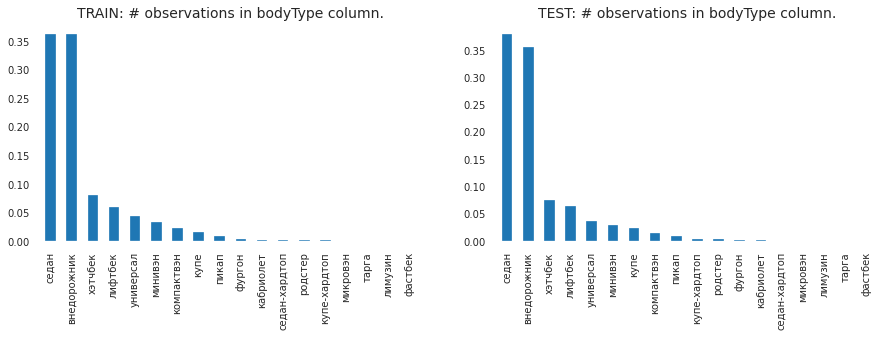

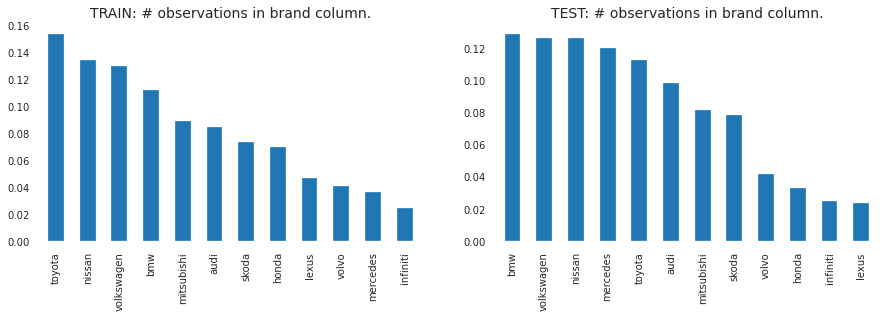

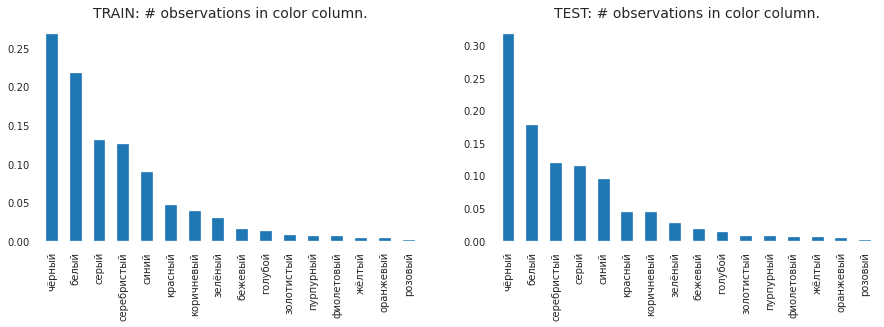

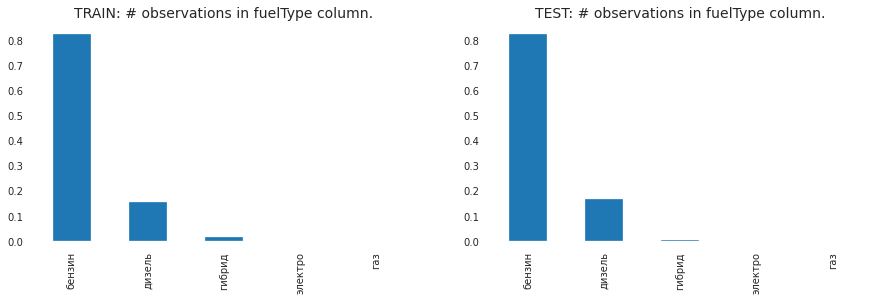

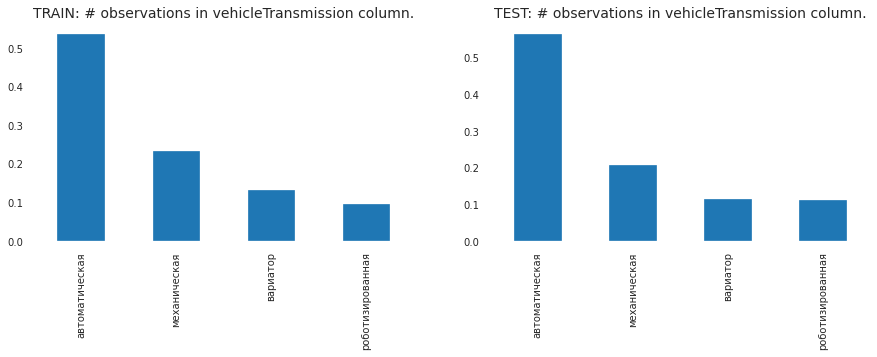

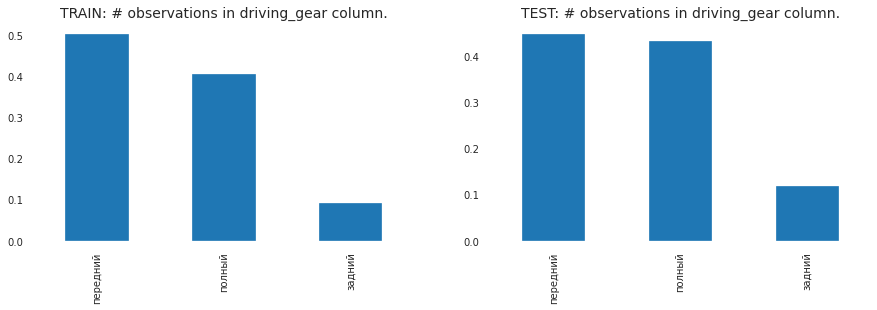

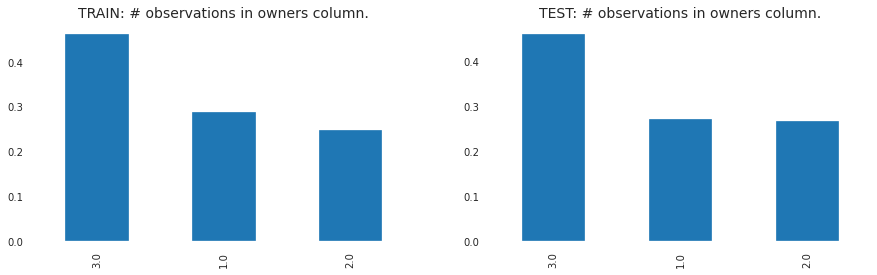

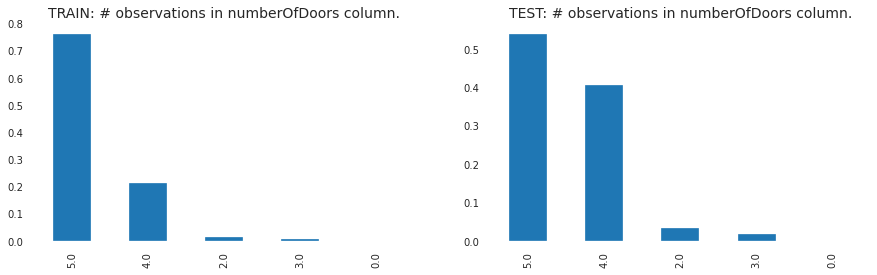

In [122]:
# Посмотрим на сбалансирование бинарных и категоральных признаков трейнового и тестового датасетов
for col in (bin_cols + cat_cols):
    if col not in ['model_name']:
        fig, ax = plt.subplots(figsize=(15, 4), ncols=2, nrows=1)
        ax[0].set_title(f'TRAIN: # observations in {col} column.', fontdict={'fontsize': 14})
        comb_df[comb_df.train == 1][col].value_counts(normalize=True).plot(kind='bar', ax=ax[0])
        ax[1].set_title(f'TEST: # observations in {col} column.', fontdict={'fontsize': 14})
        comb_df[comb_df.train == 0][col].value_counts(normalize=True).plot(kind='bar', ax=ax[1])

In [123]:
# Сделаем Label Encoding для бинарных и категоральных признаков
for colum in ['steering_wheel', 'vehicleTransmission', 'vehicle_licence', 'driving_gear',
              'fuelType', 'color', 'brand', 'bodyType']:
    comb_df[colum] = comb_df[colum].astype('category').cat.codes

cols_to_encode = list(set(comb_df.columns) & set(cat_cols))
for colum in cols_to_encode:
    comb_df[colum] = comb_df[colum].astype('category').cat.codes

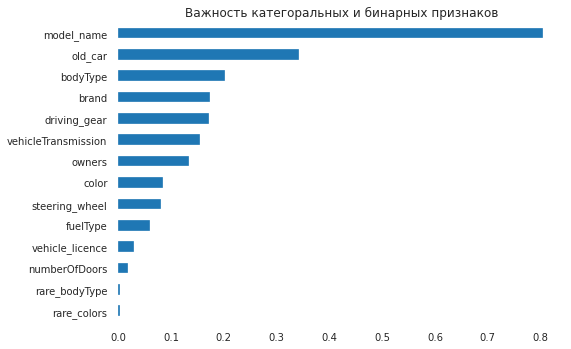

In [124]:
# Теперь посмотрим на важность бинарных и категоральных признаков
imp_cat = pd.Series(
    mutual_info_regression(
        comb_df[comb_df.train == 1][list(set(comb_df.columns) & set(cat_cols+bin_cols))], 
        comb_df[comb_df.train == 1]['price_log2'], 
        discrete_features=True), index=list(set(comb_df.columns) & set(cat_cols+bin_cols))
)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='Важность категоральных и бинарных признаков')
plt.show()

В общем выглядет всё весьма пристойно. Можно подавать в модели

## 4. Machine Learning

### 4.1. Разделение данных

Разделим трейновые данные на непосредственно трейновые и тестовые. Также обозначим данные для сабмишена

In [125]:
X = comb_df.query('train == 1').drop(['sell_id', 'price', 'price_log2', 'train'], axis=1)
X_sub = comb_df.query('train == 0').drop(['sell_id', 'price','price_log2', 'train'], axis=1)
y = comb_df.query('train == 1').price

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

### 4.2. Построение и тестирование моделей

#### 4.2.1. Наивная модель

Создадим наивную модель которая будет предсказывать стоимость автомобиля по его возрасту

In [127]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [128]:
# Находим median по экземплярам age_log2 в трейне и размечаем значения на тесте
predict = X_test['age_log2'].map(tmp_train.groupby('age_log2')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 46.69%


Точность наивной модели по метрике MAPE: 46.69%

#### 4.2.2. Catboost

Параметры для этой модели были взяты из Baseline.

In [129]:
catboost = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
catboost.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

# оцениваем точность
predict_catboost = catboost.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_catboost))*100:0.2f}%")

Точность модели по метрике MAPE: 16.59%


Точность модели по метрике MAPE: 16.59%

Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    

In [130]:
catboost_log = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
catboost_log.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

predict_catboost_log = np.exp(catboost_log.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_catboost_log))*100:0.2f}%")

Точность модели по метрике MAPE: 14.59%


Точность модели по метрике MAPE: 14.59%

Точность после передачи логарифмированного target заметно улучшилась. Будем это использовать в других моделях.

TOP Результат на сабмишене: 14.15%.
Значительно лучше чем Baseline.

#### 4.2.3. LGBMRegressor с подбором гиперпараметров

In [131]:
# Запустим модель со стандартными параметрами
lgbm_log = LGBMRegressor(random_state=RANDOM_SEED)
lgbm_log.fit(X_train, np.log(y_train))
predict_lgbm_log = np.exp(lgbm_log.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_lgbm_log))*100:0.2f}%")

Точность модели по метрике MAPE: 16.87%


Точность модели по метрике MAPE: 16.87%

In [132]:
## Создадим сетку для подбора гиперпараметров и пройдемся по ней

#lgbm_log_param_dic = {
# 'learning_rate':[0.005, 0.01, 0.015],
# 'num_leaves':[250, 500, 1000],
# 'colsample_bytree': [0.5, 1],
# 'min_child_samples': [5, 10, 20]
#}
#
#lgbm_log_grid = GridSearchCV(lgbm_log, lgbm_log_param_dic, n_jobs=-1,
#                             refit=True, cv=2, return_train_score=True, verbose=5)
#
#
#lgbm_log_grid.fit(X_train, np.log(y_train))
#print(lgbm_log_grid.best_params_)

Перебор гиперпараметров занял не один час. В итоге получился следующий результат:

Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'colsample_bytree': 0.5, 'learning_rate': 0.015, 'min_child_samples': 5, 'num_leaves': 1000}

In [133]:
# Запустим модель с подобранными гиперпараметрами
lgbm_log = LGBMRegressor(random_state=RANDOM_SEED, objective = 'regression', num_iterations = 1000, 
                           n_estimators = 1000, learning_rate = 0.015, num_leaves = 1000, max_depth = -1,  
                           min_child_samples = 5,  colsample_bytree = 0.5)
lgbm_log.fit(X_train, np.log(y_train))
predict_lgbm_log = np.exp(lgbm_log.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_lgbm_log))*100:0.2f}%")

Точность модели по метрике MAPE: 13.42%


Точность модели по метрике MAPE: 13.42%

TOP Результат на сабмишене: 13.22%.

Подбор гиперпараметров действительно помог.

#### 4.2.4. XGBoostRegressor

In [134]:
# Запустим модель с параметрами подобранными вручную по смыслу (перебор по сетке занимает много времени)
xgb_log = xgb.XGBRegressor(
    objective='reg:squarederror', 
    colsample_bytree=0.5,               
    learning_rate=0.1, 
    max_depth=12, 
    alpha=1,                   
    n_estimators=1000,
    random_state=RANDOM_SEED,
    verbose=1, 
    n_jobs=-1)

xgb_log.fit(X_train, np.log(y_train))
predict_xgb_log = np.exp(xgb_log.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_xgb_log))*100:0.2f}%")

[01:19:37] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Точность модели по метрике MAPE: 13.32%


Точность модели по метрике MAPE: 13.32%

TOP Результат на сабмишене: 13.23%

#### 4.2.5. Random forest 

In [135]:
# Запустим модель со стандартными параметрами
rf_log = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
rf_log.fit(X_train, np.log(y_train))
predict_rf_log = np.exp(rf_log.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_rf_log) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s


Точность модели по метрике MAPE: 13.53%.


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


Точность модели по метрике MAPE: 13.32%

TOP Результат на сабмишене 12.44%

Подбор гиперпараметров не улучшил результата.

#### 4.2.6. Extra Tree Regressor с подбором гиперпараметров

In [136]:
# Запустим модель со стандартными параметрами
etr_log = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
etr_log.fit(X_train, np.log(y_train))
predict_etr_log = np.exp(etr_log.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_etr_log))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   45.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s


Точность модели по метрике MAPE: 13.57%


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


Точность модели по метрике MAPE: 13.57%

TOP Результат на сабмишене **10.72% (лучший результат)**

In [137]:
## Подберем гиперпараметры с помощью hyperopt
#hp.uniform('n_estimators',100,500),
#hp.choice("n_estimators", [int(x) for x in np.linspace(200, 1000, num = 17)])
#
#def objective(params):
#    model=ExtraTreesRegressor(
#        n_estimators=int(params['n_estimators']),
#        max_depth=int(params['max_depth']),
#        min_samples_leaf=int(params['min_samples_leaf']),
#        min_samples_split=int(params['min_samples_split']),
#        bootstrap=params['bootstrap'],
#        max_features=params['max_features'],
#        random_state=RANDOM_SEED,
#        n_jobs=-1
#    )
#    model.fit(X_train, np.log(y_train))
#    pred=model.predict(X_test)
#    score=mape(y_test,np.exp(pred))
#    return score
#
#def optimize(trial):
#    params={
#        'n_estimators': hp.uniform('n_estimators',100,500),
#        'max_features': hp.choice("max_features", ['auto', 'sqrt']),
#        'max_depth': hp.uniform('max_depth',5,15),
#        'min_samples_split': hp.uniform('min_samples_split',2,10),
#        'min_samples_leaf': hp.uniform('min_samples_leaf',1,5),
#        'bootstrap': hp.choice("bootstrap", [True, False])
#    }
#    best=fmin(fn=objective, space=params, algo=tpe.suggest, trials=trial, max_evals=100, rstate=np.random.RandomState(RANDOM_SEED))
#    return best
#
#trial=Trials()
#best=optimize(trial)

Подбор занял около часа и в итоге дал следующий результат:

best = {'bootstrap': 1,
 'max_depth': 14.186468459692794,
 'max_features': 0,
 'min_samples_leaf': 1.096652759290328,
 'min_samples_split': 5.747686307061846,
 'n_estimators': 412.078171291474}

In [138]:
# Запустим модель с подобранными гирерпараметрами
etr_log_hp = ExtraTreesRegressor(random_state=RANDOM_SEED, 
                                   n_jobs=-1, 
                                   verbose=1, 
                                   n_estimators = 412, 
                                   min_samples_split = 6, 
                                   min_samples_leaf = 1, 
                                   max_features = 'auto', 
                                   max_depth = 14, 
                                   bootstrap = 1)

etr_log_hp.fit(X_train, np.log(y_train))
predict_etr_log_hp = np.exp(etr_log_hp.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_etr_log_hp))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 412 out of 412 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s


Точность модели по метрике MAPE: 15.64%


[Parallel(n_jobs=4)]: Done 412 out of 412 | elapsed:    1.7s finished


Точность модели по метрике MAPE: 15.64%

TOP Результат на сабмишене 16.65%

Подбор гирепараметров к сожалению не улучшил результат.

Также подбор вручную параметров n_estimators, max_depth, min_samples_split, min_samples_leaf, ccp_alpha не увенчался успехом. Увеличение n_estimator дало незначительное улучшение и при этом сильно замедлело модель, подбор остальных параметров лишь ухудшил результат.

#### 4.2.7. Stacking

Объединим три наиболее удачные модели в одну

In [139]:
#estimators = [
#    ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
#    ('rf', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
#    ('lgmb', LGBMRegressor(random_state=RANDOM_SEED, objective = 'regression', num_iterations = 1000, 
#                           n_estimators = 1000, learning_rate = 0.015, num_leaves = 1000, max_depth = -1,  
#                           min_child_samples = 5,  colsample_bytree = 0.5))
#]
#
#stacking_log = StackingRegressor(
#    estimators=estimators,
#    final_estimator=LinearRegression()
#)
#
#stacking_log.fit(X_train, np.log(y_train))
#
#predict_stacking_log = np.exp(staking_log.predict(X_test))
#
#print(f"The MAPE mertic for the default StackingRegressor model: {(mape(y_test, predict_stacking_log) * 100):0.2f}%.")

Точность модели по метрике MAPE: 12.86%

TOP Результат на сабмишене: 11.86%

Stacking реально улучшил МАРЕ: результат 12.86% значительно лучше каждой модели по отдельности (etr = 13.57%, rf = 13.53%, lgmb = 13.42%). Однако на сабмишене рекорда не было. Тут надо отметить что со временем результаты на сабмишене просели примерно на 1% по непонятным причинам. Топовый результат в 10.72% с ExtraTreeRegressor был получен в начале, и после перестал воспроизводиться.

В общем главное что stacking таки работает.

Примечание: Kaggle Notebook плохо справлялся со стэкингом из-за жесткого ограничения доступной памяти. Приходилось использовать Jupyter Notebook.



## 5. Submission

In [140]:
VERSION=38
predict_submission = np.exp(etr_log.predict(X_sub))
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished


,sell_id,price
0,1100575026,5.490000e+05
1,1100549428,8.950000e+05
2,1100658222,1.035181e+06
3,1100937408,7.377136e+05
4,1101037972,6.491214e+05
5,1100912634,8.353816e+05
6,1101228730,6.802995e+05
7,1100165896,4.558074e+05
8,1100768262,2.006315e+06
9,1101218501,7.707313e+05


## 6. Conclusions

Хорошего результата удалось добиться прежде всего за счет огромного количества данных (изначально в объединенном датасете было под миллион строк). Важным моментом было грамотно объединить пять датасетов в один.

Обилие данных позволило удалить излишки с которыми тяжело работать.
Соответственно, точность можно было бы повысить если более скрупулезно вникать в записи. Например поработать со столбцом где дана комплектация автомобиля (очевидно влияющая на цену) или со столбцом где дано от описание владельца (пошариться по ключевым словам).

В общем удалось отработать материал данный в Юните на практике и добиться неплохого результата.

